In [14]:
import torch
import torch.nn.functional as F

import os
import argparse
from tqdm import tqdm

from data import get_dataloader

import math
import seaborn as sns
from matplotlib import pyplot as plt

def val(net, data_loader):
    with torch.no_grad():
        net.eval()
        n_correct = 0
        n_total = 0

        for images, targets in data_loader:
            images, targets = images.to(args.device), targets.to(args.device)

            logits = net(images)
            prediction = logits.argmax(-1)

            n_correct += (prediction==targets).sum()
            n_total += targets.shape[0]

        acc = n_correct / n_total * 100

    return acc


def save(model, args):
    if not os.path.exists(args.checkpoint):
        os.mkdir(args.checkpoint)
    file_name = f'{args.model}_{args.attack_type}_{args.trigger_size}_{args.poisoning_rate}_{args.manual_seed}.pth'
    path = os.path.join(args.checkpoint, file_name)
    torch.save(model.state_dict(), path)
    print(f'Checkpoint saved at {path}')

def load_checkpoint(args):
    file_name = f'{args.model}_{args.attack_type}_{args.trigger_size}_{args.poisoning_rate}_{args.manual_seed}.pth'
    path = os.path.join(args.checkpoint, file_name)
    ckpt = torch.load(path)
    print(f'Checkpoint loaded from {path}')
    return ckpt

class Args():
    model = 'resnet18'
    workers = 4
    batch_size = 64
    lr = 1e-1
    momentum = 0.9
    weight_decay = 5e-4
    epochs = 150
    u = 3
    checkpoint = './ckpt'
    manual_seed = 0
    device = 'cuda:0'
    dataset = 'cifar10'
    dataset_dir = './dataset'
    attack_type = 'blended'
    target_label = 0
    poisoning_rate = 0.1
    trigger_size = 32
    
args = Args()

In [87]:
import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    """Basic Block for resnet 18 and resnet 34
    """

    #BasicBlock and BottleNeck block
    #have different output size
    #we use class attribute expansion
    #to distinct
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        #residual function
        self.residual_function = nn.Sequential(
            Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            BatchNorm2d(out_channels * BasicBlock.expansion)
        )

        #shortcut
        self.shortcut = nn.Sequential()

        #the shortcut output dimension is not the same with residual function
        #use 1*1 convolution to match the dimension
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))


class ResNet(nn.Module):

    def __init__(self, block, num_block, num_classes=1000):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            BatchNorm2d(64),
            nn.ReLU(inplace=True))
        #we use a different inputsize than the original paper
        #so conv2_x's stride is 1
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        """make resnet layers(by layer i didnt mean this 'layer' was the
        same as a neuron netowork layer, ex. conv layer), one layer may
        contain more than one residual block
        Args:
            block: block type, basic block or bottle neck block
            out_channels: output depth channel number of this layer
            num_blocks: how many blocks per layer
            stride: the stride of the first block of this layer
        Return:
            return a resnet layer
        """

        # we have num_block blocks per layer, the first block
        # could be 1 or 2, other blocks would always be 1
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)   
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        feat = output.view(output.size(0), -1)
        output = self.fc(feat)

        return output

def resnet18(num_classes):
    """ return a ResNet 18 object
    """
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

def get_model(model, num_classes):
    if model == 'resnet18':
        return resnet18(num_classes)
    else:
        raise
        
class BatchNorm2d(nn.BatchNorm2d):
    def __init__(self, num_features):
        super().__init__(num_features)
        self.feat = None
    
    def forward(self, x):
#         n, c, h, w = x.shape
#         if self.feat is None:
#             self.feat = x.reshape(n, c, -1).max(-1)[0]
        return super().forward(x)
    
class Conv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, 
            stride=1, padding=0, dilation=1, bias=True):
        super(Conv2d, self).__init__(in_channels, out_channels, 
                                     kernel_size, stride, padding, dilation, 
                                     groups=1, bias=bias)
        self.feat = None

    def forward(self, input):
        output = super().forward(input)
        self.feat = output
        return output

In [88]:
ckpt = load_checkpoint(args)
state_dict, trigger = ckpt['state_dict'], ckpt['trigger']
num_classes, train_loader, val_loader, holdout_loader, test_clean_loader, test_poisoned_loader, _ = get_dataloader(args, trigger)
net = get_model(args.model, num_classes).to(args.device)
net.load_state_dict(state_dict)
    
print('Before prunning')
acc = val(net, val_loader)
print('Validation accuracy: %.2f' % acc)
acc, asr = val(net, test_clean_loader), val(net, test_poisoned_loader)
print('Test clean accuracy: %.2f' % acc)
print('Test attack success rate: %.2f' % asr)

Checkpoint loaded from ./ckpt/resnet18_blended_32_0.1_0.pth
Files already downloaded and verified
Files already downloaded and verified
Before prunning
Validation accuracy: 94.10
Test clean accuracy: 94.71
Test attack success rate: 99.94


In [4]:
def skewness(x):
    return (x - x.mean(0)).pow(3).mean(0) / (x - x.mean(0)).pow(2).mean(0).pow(3).sqrt()

def kurtosis(x):
    return (x - x.mean(0)).pow(4).mean(0) / (x - x.mean(0)).pow(2).mean(0).pow(4).sqrt()

In [5]:
images = torch.Tensor()

with torch.no_grad():
    for data in train_loader:
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        inputs = inputs[labels==0].cpu()

        images = torch.cat([images, inputs])

In [64]:
ckpt = load_checkpoint(args)
state_dict, trigger = ckpt['state_dict'], ckpt['trigger']
net = get_model(args.model, num_classes).to(args.device)
net.load_state_dict(state_dict)
with torch.no_grad():
    net(images[:1000].to(args.device))

for i, (name, m) in enumerate(net.named_modules()):
    if isinstance(m, nn.BatchNorm2d):
            print(i)
        
            feat = m.feat
            feat = (feat - feat.mean(0)) / feat.std(0)

            skws = skewness(feat)
            kurt = kurtosis(feat)
            sbc = (skws**2+1)/kurt

            index = sbc > (sbc.mean()+2.5*sbc.std())
#             index = sbc.argmax()
            print(torch.where(index)[0])

            weight = m.weight.detach()
            weight[index] = 0
            state_dict = m.state_dict()
            state_dict['weight'] = weight
            m.load_state_dict(state_dict)
            
            acc, asr = val(net, test_clean_loader), val(net, test_poisoned_loader)
            print('Test clean accuracy: %.2f' % acc)
            print('Test attack success rate: %.2f' % asr)

Checkpoint loaded from ./ckpt/resnet18_badnets_3_0.1_0.pth
3
tensor([], device='cuda:0', dtype=torch.int64)
Test clean accuracy: 93.71
Test attack success rate: 100.00
9
tensor([44], device='cuda:0')
Test clean accuracy: 93.68
Test attack success rate: 100.00
12
tensor([], device='cuda:0', dtype=torch.int64)
Test clean accuracy: 93.68
Test attack success rate: 100.00
17
tensor([26], device='cuda:0')
Test clean accuracy: 93.62
Test attack success rate: 100.00
20
tensor([50], device='cuda:0')
Test clean accuracy: 93.60
Test attack success rate: 100.00
26
tensor([90], device='cuda:0')
Test clean accuracy: 93.59
Test attack success rate: 100.00
29
tensor([  2,  62,  78, 126], device='cuda:0')
Test clean accuracy: 93.53
Test attack success rate: 99.80
32
tensor([89], device='cuda:0')
Test clean accuracy: 93.51
Test attack success rate: 99.78
36
tensor([15, 54, 60, 67], device='cuda:0')
Test clean accuracy: 93.63
Test attack success rate: 95.41
39
tensor([ 42, 126], device='cuda:0')
Test cle

In [63]:
ckpt = load_checkpoint(args)
state_dict, trigger = ckpt['state_dict'], ckpt['trigger']
net = get_model(args.model, num_classes).to(args.device)
net.load_state_dict(state_dict)
with torch.no_grad():
    net(images[:1000].to(args.device))

for i, (name, m) in enumerate(net.named_modules()):
    if isinstance(m, nn.BatchNorm2d):
            print(i)
        
            feat = m.feat
            feat = (feat - feat.mean(0)) / feat.std(0)

            skws = skewness(feat)
            kurt = kurtosis(feat)
            sbc = (skws**2+1)/kurt

#             index = sbc > (sbc.mean()+2.5*sbc.std())
            index = sbc.argmax()
            print(index)

            weight = m.weight.detach()
            weight[index] = 0
            state_dict = m.state_dict()
            state_dict['weight'] = weight
            m.load_state_dict(state_dict)
            
            acc, asr = val(net, test_clean_loader), val(net, test_poisoned_loader)
            print('Test clean accuracy: %.2f' % acc)
            print('Test attack success rate: %.2f' % asr)

Checkpoint loaded from ./ckpt/resnet18_badnets_3_0.1_0.pth
3
tensor(50, device='cuda:0')
Test clean accuracy: 93.47
Test attack success rate: 100.00
9
tensor(44, device='cuda:0')
Test clean accuracy: 93.37
Test attack success rate: 100.00
12
tensor(61, device='cuda:0')
Test clean accuracy: 93.28
Test attack success rate: 100.00
17
tensor(26, device='cuda:0')
Test clean accuracy: 93.26
Test attack success rate: 100.00
20
tensor(50, device='cuda:0')
Test clean accuracy: 93.31
Test attack success rate: 100.00
26
tensor(90, device='cuda:0')
Test clean accuracy: 93.25
Test attack success rate: 100.00
29
tensor(62, device='cuda:0')
Test clean accuracy: 93.29
Test attack success rate: 99.79
32
tensor(89, device='cuda:0')
Test clean accuracy: 93.27
Test attack success rate: 99.78
36
tensor(15, device='cuda:0')
Test clean accuracy: 93.26
Test attack success rate: 99.63
39
tensor(126, device='cuda:0')
Test clean accuracy: 93.24
Test attack success rate: 97.77
45
tensor(211, device='cuda:0')
Test

In [12]:
import geoopt
from geoopt.optim import RiemannianAdam
manifold = geoopt.Stiefel()
orth_mat = geoopt.ManifoldParameter(manifold.random(64, 64))
opt = RiemannianAdam([orth_mat])

In [50]:
feat = m.feat.cpu()

In [62]:
X = torch.randn(500, 20)
M = torch.randn(20, 20)
X.matmul(M)

tensor([[ 3.2212,  1.7627, -4.9030,  ..., -1.2574, -2.0356, -2.8771],
        [-4.7068,  2.5055,  0.3526,  ...,  3.4414,  1.8447,  4.1826],
        [-1.5661,  9.3508,  0.6080,  ...,  0.3347, -1.5445, -3.0414],
        ...,
        [-2.6834,  6.8815,  2.8761,  ..., -0.9990,  1.3341, -3.3999],
        [12.0926, -5.3599, -7.0266,  ...,  0.5603,  4.5728, -0.5718],
        [ 4.8817, -8.4780, -2.5762,  ..., -1.5902,  0.6534,  3.4955]])

In [65]:
torch.einsum('ij, jz-> iz', X, M)

tensor([[ 3.2212,  1.7627, -4.9030,  ..., -1.2574, -2.0356, -2.8771],
        [-4.7068,  2.5055,  0.3526,  ...,  3.4414,  1.8447,  4.1826],
        [-1.5661,  9.3508,  0.6080,  ...,  0.3347, -1.5445, -3.0414],
        ...,
        [-2.6834,  6.8815,  2.8761,  ..., -0.9990,  1.3341, -3.3999],
        [12.0926, -5.3599, -7.0266,  ...,  0.5603,  4.5728, -0.5718],
        [ 4.8817, -8.4780, -2.5762,  ..., -1.5902,  0.6534,  3.4955]])

In [74]:
m(feat.cuda())

tensor([[[[ 1.4378e-02,  2.7418e-02,  2.6919e-02,  ...,  2.6187e-02,
            2.4346e-02,  2.0044e-02],
          [-1.6543e-02, -1.3235e-02, -1.4119e-02,  ..., -1.4327e-02,
           -1.4537e-02, -4.7737e-03],
          [ 2.9801e-03,  1.0075e-02,  1.0653e-02,  ..., -1.0831e-02,
           -1.1061e-02, -9.0780e-05],
          ...,
          [-6.6140e-03, -5.3784e-03, -4.8618e-03,  ..., -6.7420e-03,
           -8.6647e-03, -5.8501e-04],
          [-2.7648e-03,  3.7947e-03,  4.1836e-03,  ...,  4.2367e-03,
            2.7147e-03,  1.1077e-02],
          [-7.5519e-03, -2.7774e-03, -2.0664e-03,  ..., -9.2500e-04,
           -3.6712e-03,  3.9207e-03]],

         [[-1.2850e-01, -2.0586e-01, -1.5758e-01,  ..., -1.7923e-01,
           -1.5850e-01, -9.3728e-02],
          [ 4.9881e-02, -4.2816e-02, -1.6496e-02,  ..., -8.8875e-02,
           -4.7279e-02, -2.7937e-02],
          [-1.6249e-01, -1.5341e-01, -1.1973e-01,  ..., -1.1459e-01,
           -4.2736e-02, -8.3009e-02],
          ...,
     

In [77]:
params = m.state_dict()

In [73]:
out = torch.einsum('nchw, ck-> nkhw', feat, orth_mat)
out = torch.einsum('nkhw, kc-> nchw', out, orth_mat.T)
m(out.cuda())

tensor([[[[ 1.4378e-02,  2.7418e-02,  2.6919e-02,  ...,  2.6188e-02,
            2.4347e-02,  2.0044e-02],
          [-1.6543e-02, -1.3235e-02, -1.4119e-02,  ..., -1.4328e-02,
           -1.4538e-02, -4.7744e-03],
          [ 2.9803e-03,  1.0075e-02,  1.0653e-02,  ..., -1.0831e-02,
           -1.1060e-02, -8.9460e-05],
          ...,
          [-6.6140e-03, -5.3784e-03, -4.8618e-03,  ..., -6.7425e-03,
           -8.6649e-03, -5.8524e-04],
          [-2.7648e-03,  3.7947e-03,  4.1836e-03,  ...,  4.2367e-03,
            2.7148e-03,  1.1077e-02],
          [-7.5519e-03, -2.7774e-03, -2.0664e-03,  ..., -9.2504e-04,
           -3.6712e-03,  3.9206e-03]],

         [[-1.2850e-01, -2.0586e-01, -1.5758e-01,  ..., -1.7923e-01,
           -1.5853e-01, -9.3715e-02],
          [ 4.9881e-02, -4.2816e-02, -1.6496e-02,  ..., -8.8876e-02,
           -4.7269e-02, -2.7930e-02],
          [-1.6249e-01, -1.5341e-01, -1.1973e-01,  ..., -1.1458e-01,
           -4.2739e-02, -8.3024e-02],
          ...,
     

In [80]:
new_params = m.state_dict()
weight = new_params['weight'].cpu()
weight = torch.einsum('nchw, ck-> nkhw', weight, orth_mat)
weight = torch.einsum('nkhw, kc-> nchw', weight, orth_mat.T)
new_params['weight'] = weight
m.load_state_dict(new_params)
m(feat.cuda())

tensor([[[[ 1.4379e-02,  2.7418e-02,  2.6920e-02,  ...,  2.6188e-02,
            2.4347e-02,  2.0045e-02],
          [-1.6542e-02, -1.3235e-02, -1.4118e-02,  ..., -1.4327e-02,
           -1.4536e-02, -4.7731e-03],
          [ 2.9814e-03,  1.0077e-02,  1.0657e-02,  ..., -1.0830e-02,
           -1.1060e-02, -9.0034e-05],
          ...,
          [-6.6133e-03, -5.3777e-03, -4.8605e-03,  ..., -6.7408e-03,
           -8.6636e-03, -5.8426e-04],
          [-2.7647e-03,  3.7948e-03,  4.1842e-03,  ...,  4.2373e-03,
            2.7153e-03,  1.1077e-02],
          [-7.5495e-03, -2.7750e-03, -2.0636e-03,  ..., -9.2204e-04,
           -3.6692e-03,  3.9214e-03]],

         [[-1.2849e-01, -2.0585e-01, -1.5758e-01,  ..., -1.7923e-01,
           -1.5850e-01, -9.3727e-02],
          [ 4.9884e-02, -4.2813e-02, -1.6493e-02,  ..., -8.8873e-02,
           -4.7273e-02, -2.7936e-02],
          [-1.6249e-01, -1.5340e-01, -1.1973e-01,  ..., -1.1458e-01,
           -4.2728e-02, -8.3008e-02],
          ...,
     

Checkpoint loaded from ./ckpt/resnet18_blended_32_0.1_0.pth
tensor(0.7217, grad_fn=<SelectBackward0>) tensor(0.7000, grad_fn=<SelectBackward0>) tensor(0.7387, grad_fn=<SelectBackward0>)
tensor(0.8178, grad_fn=<SelectBackward0>) tensor(0.5145, grad_fn=<SelectBackward0>) tensor(1.0714, grad_fn=<SelectBackward0>)
tensor(0.8170, grad_fn=<SelectBackward0>) tensor(0.5300, grad_fn=<SelectBackward0>) tensor(0.7569, grad_fn=<SelectBackward0>)
tensor(0.8182, grad_fn=<SelectBackward0>) tensor(0.5225, grad_fn=<SelectBackward0>) tensor(0.9278, grad_fn=<SelectBackward0>)
tensor(0.8230, grad_fn=<SelectBackward0>) tensor(0.5164, grad_fn=<SelectBackward0>) tensor(1.0155, grad_fn=<SelectBackward0>)
tensor(0.8264, grad_fn=<SelectBackward0>) tensor(0.5086, grad_fn=<SelectBackward0>) tensor(0.7226, grad_fn=<SelectBackward0>)
tensor(0.8277, grad_fn=<SelectBackward0>) tensor(0.5206, grad_fn=<SelectBackward0>) tensor(0.8864, grad_fn=<SelectBackward0>)
tensor(0.8250, grad_fn=<SelectBackward0>) tensor(0.4931, g

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


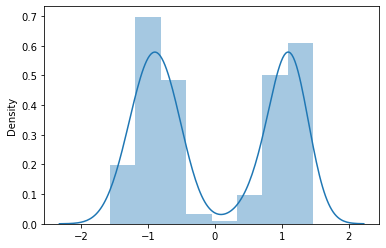

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


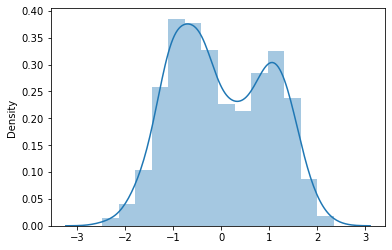

Test clean accuracy: 94.58
Test attack success rate: 99.56
tensor(0.7243, grad_fn=<SelectBackward0>) tensor(0.7033, grad_fn=<SelectBackward0>) tensor(1.3638, grad_fn=<SelectBackward0>)
tensor(0.8171, grad_fn=<SelectBackward0>) tensor(0.5995, grad_fn=<SelectBackward0>) tensor(1.0228, grad_fn=<SelectBackward0>)
tensor(0.8525, grad_fn=<SelectBackward0>) tensor(0.6225, grad_fn=<SelectBackward0>) tensor(1.2308, grad_fn=<SelectBackward0>)
tensor(0.8586, grad_fn=<SelectBackward0>) tensor(0.6430, grad_fn=<SelectBackward0>) tensor(1.4661, grad_fn=<SelectBackward0>)
tensor(0.8633, grad_fn=<SelectBackward0>) tensor(0.6534, grad_fn=<SelectBackward0>) tensor(1.0118, grad_fn=<SelectBackward0>)
tensor(0.8650, grad_fn=<SelectBackward0>) tensor(0.6499, grad_fn=<SelectBackward0>) tensor(1.1955, grad_fn=<SelectBackward0>)
tensor(0.8691, grad_fn=<SelectBackward0>) tensor(0.6487, grad_fn=<SelectBackward0>) tensor(1.2615, grad_fn=<SelectBackward0>)
tensor(0.8703, grad_fn=<SelectBackward0>) tensor(0.6702, gr

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


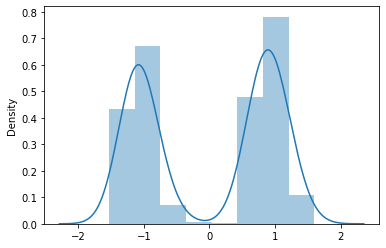

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


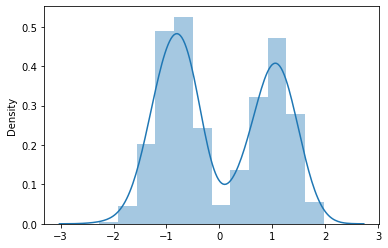

Test clean accuracy: 94.48
Test attack success rate: 99.96
tensor(0.8282, grad_fn=<SelectBackward0>) tensor(0.7746, grad_fn=<SelectBackward0>) tensor(1.0920, grad_fn=<SelectBackward0>)
tensor(0.8861, grad_fn=<SelectBackward0>) tensor(0.6819, grad_fn=<SelectBackward0>) tensor(0.9532, grad_fn=<SelectBackward0>)
tensor(0.8981, grad_fn=<SelectBackward0>) tensor(0.6661, grad_fn=<SelectBackward0>) tensor(0.3108, grad_fn=<SelectBackward0>)
tensor(0.9053, grad_fn=<SelectBackward0>) tensor(0.6997, grad_fn=<SelectBackward0>) tensor(0.5611, grad_fn=<SelectBackward0>)
tensor(0.9104, grad_fn=<SelectBackward0>) tensor(0.6690, grad_fn=<SelectBackward0>) tensor(1.0700, grad_fn=<SelectBackward0>)
tensor(0.9125, grad_fn=<SelectBackward0>) tensor(0.6904, grad_fn=<SelectBackward0>) tensor(0.8256, grad_fn=<SelectBackward0>)
tensor(0.9170, grad_fn=<SelectBackward0>) tensor(0.7057, grad_fn=<SelectBackward0>) tensor(0.6635, grad_fn=<SelectBackward0>)
tensor(0.9172, grad_fn=<SelectBackward0>) tensor(0.6939, gr

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


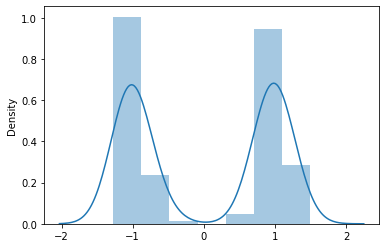

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


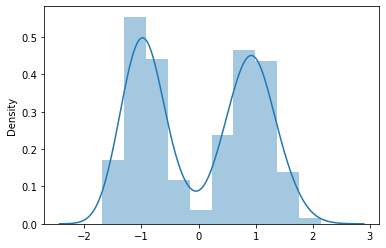

Test clean accuracy: 94.33
Test attack success rate: 99.96
tensor(0.7620, grad_fn=<SelectBackward0>) tensor(0.7477, grad_fn=<SelectBackward0>) tensor(0.9272, grad_fn=<SelectBackward0>)
tensor(0.8405, grad_fn=<SelectBackward0>) tensor(0.5861, grad_fn=<SelectBackward0>) tensor(0.8282, grad_fn=<SelectBackward0>)
tensor(0.8559, grad_fn=<SelectBackward0>) tensor(0.5990, grad_fn=<SelectBackward0>) tensor(0.7395, grad_fn=<SelectBackward0>)
tensor(0.8570, grad_fn=<SelectBackward0>) tensor(0.5915, grad_fn=<SelectBackward0>) tensor(1.0790, grad_fn=<SelectBackward0>)
tensor(0.8604, grad_fn=<SelectBackward0>) tensor(0.6445, grad_fn=<SelectBackward0>) tensor(0.9657, grad_fn=<SelectBackward0>)
tensor(0.8666, grad_fn=<SelectBackward0>) tensor(0.6089, grad_fn=<SelectBackward0>) tensor(1.2144, grad_fn=<SelectBackward0>)
tensor(0.8665, grad_fn=<SelectBackward0>) tensor(0.6386, grad_fn=<SelectBackward0>) tensor(0.9664, grad_fn=<SelectBackward0>)
tensor(0.8691, grad_fn=<SelectBackward0>) tensor(0.6183, gr

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


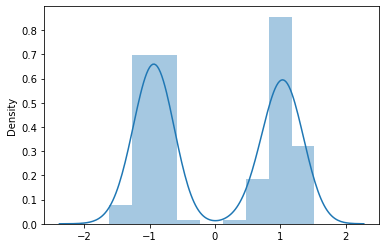

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


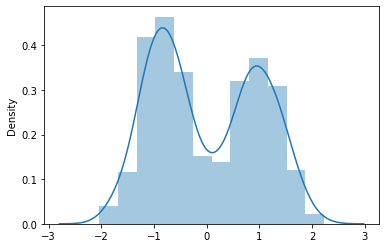

Test clean accuracy: 94.29
Test attack success rate: 99.98
tensor(0.6471, grad_fn=<SelectBackward0>) tensor(0.6383, grad_fn=<SelectBackward0>) tensor(1.4274, grad_fn=<SelectBackward0>)


KeyboardInterrupt: 

In [105]:
ckpt = load_checkpoint(args)
state_dict, trigger = ckpt['state_dict'], ckpt['trigger']
net = get_model(args.model, num_classes).to(args.device)
net.load_state_dict(state_dict)

for i, (name, m) in enumerate(net.named_modules()):
    if isinstance(m, nn.Conv2d):
#         if i == 76:
            with torch.no_grad():
                net(images[torch.randn(9000).topk(1000)[1]].to(args.device))
            n, c, w, h = m.feat.shape
            feat = m.feat.detach().cpu().reshape(n, c, -1).max(-1)[0]
            orth_mat = geoopt.ManifoldParameter(manifold.random(m.weight.shape[0], m.weight.shape[0]))
            opt = RiemannianAdam([orth_mat], lr=1e-3)
            for i in range(10000):
                out = feat.matmul(orth_mat)
                out = (out - out.mean(0)) / out.std(0)

                skws = skewness(out)
                kurt = kurtosis(out)
                sbc = (skws**2+1)/kurt

                index = sbc.topk(2)[1]

                entropy = kernel_entropy(out[index], n_bars=20, bw=0.1)

                if i % 1000 == 0:
                    print(sbc[index[0]], sbc[index[1]], entropy[index[0]])
    #                 print(sbc[index])
                loss = -sbc[index[0]] + sbc[index[1]] #+ entropy[index[0]]
                loss.backward()

    #             print(max_sbc, entropy)
    #             print(out[:, index].mean(), out[:, index].std())
                opt.step()


            sns.distplot(out[:, index[0]].cpu().detach())
            plt.show()
            sns.distplot(out[:, index[1]].cpu().detach())
            plt.show()

            weight = m.weight.cpu()
            orth_mat.detach_()
            orth_mat[:, index[0]] = 0
            new_weight = torch.einsum('oihw, ok-> kihw', weight, orth_mat)
            new_weight = torch.einsum('kihw, ko-> oihw', new_weight, orth_mat.T)

            state_dict = m.state_dict()
            state_dict['weight'] = new_weight
            m.load_state_dict(state_dict)
            acc, asr = val(net, test_clean_loader), val(net, test_poisoned_loader)
            print('Test clean accuracy: %.2f' % acc)
            print('Test attack success rate: %.2f' % asr)

Checkpoint loaded from ./ckpt/resnet18_blended_32_0.1_0.pth
2
tensor(0.7094, grad_fn=<SelectBackward0>) tensor(0.6892, grad_fn=<SelectBackward0>) tensor(0.9820, grad_fn=<SelectBackward0>)
tensor(0.8157, grad_fn=<SelectBackward0>) tensor(0.5037, grad_fn=<SelectBackward0>) tensor(0.7430, grad_fn=<SelectBackward0>)
tensor(0.8242, grad_fn=<SelectBackward0>) tensor(0.5232, grad_fn=<SelectBackward0>) tensor(1.4258, grad_fn=<SelectBackward0>)
tensor(0.8248, grad_fn=<SelectBackward0>) tensor(0.5069, grad_fn=<SelectBackward0>) tensor(0.7388, grad_fn=<SelectBackward0>)
tensor(0.8262, grad_fn=<SelectBackward0>) tensor(0.5422, grad_fn=<SelectBackward0>) tensor(0.7407, grad_fn=<SelectBackward0>)
tensor(0.8296, grad_fn=<SelectBackward0>) tensor(0.5502, grad_fn=<SelectBackward0>) tensor(0.8593, grad_fn=<SelectBackward0>)
tensor(0.8322, grad_fn=<SelectBackward0>) tensor(0.5771, grad_fn=<SelectBackward0>) tensor(0.6799, grad_fn=<SelectBackward0>)
tensor(0.8322, grad_fn=<SelectBackward0>) tensor(0.5180,

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


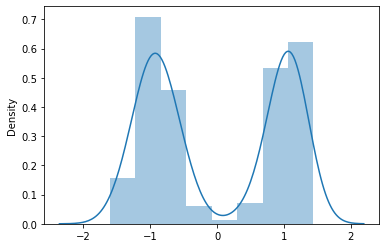

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


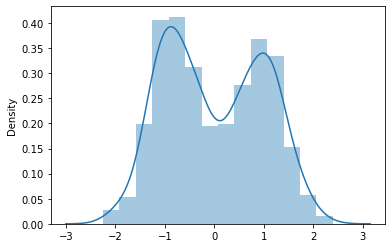

Test clean accuracy: 94.55
Test attack success rate: 99.66
8
tensor(0.7392, grad_fn=<SelectBackward0>) tensor(0.7252, grad_fn=<SelectBackward0>) tensor(0.9198, grad_fn=<SelectBackward0>)
tensor(0.8430, grad_fn=<SelectBackward0>) tensor(0.6474, grad_fn=<SelectBackward0>) tensor(1.4466, grad_fn=<SelectBackward0>)
tensor(0.8614, grad_fn=<SelectBackward0>) tensor(0.6277, grad_fn=<SelectBackward0>) tensor(0.2591, grad_fn=<SelectBackward0>)
tensor(0.8643, grad_fn=<SelectBackward0>) tensor(0.6264, grad_fn=<SelectBackward0>) tensor(1.0423, grad_fn=<SelectBackward0>)
tensor(0.8690, grad_fn=<SelectBackward0>) tensor(0.6357, grad_fn=<SelectBackward0>) tensor(1.0319, grad_fn=<SelectBackward0>)
tensor(0.8719, grad_fn=<SelectBackward0>) tensor(0.6439, grad_fn=<SelectBackward0>) tensor(1.4058, grad_fn=<SelectBackward0>)
tensor(0.8743, grad_fn=<SelectBackward0>) tensor(0.6506, grad_fn=<SelectBackward0>) tensor(1.4175, grad_fn=<SelectBackward0>)
tensor(0.8749, grad_fn=<SelectBackward0>) tensor(0.6601, 

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


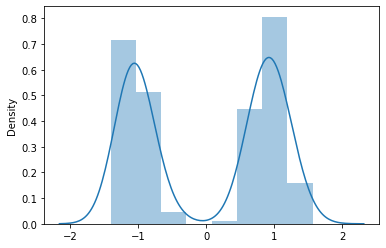

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


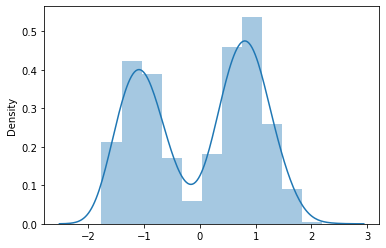

Test clean accuracy: 94.50
Test attack success rate: 99.90
11
tensor(0.7619, grad_fn=<SelectBackward0>) tensor(0.7613, grad_fn=<SelectBackward0>) tensor(1.4342, grad_fn=<SelectBackward0>)
tensor(0.8800, grad_fn=<SelectBackward0>) tensor(0.6847, grad_fn=<SelectBackward0>) tensor(1.1452, grad_fn=<SelectBackward0>)
tensor(0.9006, grad_fn=<SelectBackward0>) tensor(0.6618, grad_fn=<SelectBackward0>) tensor(0.9967, grad_fn=<SelectBackward0>)
tensor(0.8999, grad_fn=<SelectBackward0>) tensor(0.6784, grad_fn=<SelectBackward0>) tensor(0.8986, grad_fn=<SelectBackward0>)
tensor(0.9073, grad_fn=<SelectBackward0>) tensor(0.6978, grad_fn=<SelectBackward0>) tensor(1.0592, grad_fn=<SelectBackward0>)
tensor(0.9098, grad_fn=<SelectBackward0>) tensor(0.6808, grad_fn=<SelectBackward0>) tensor(0.5438, grad_fn=<SelectBackward0>)
tensor(0.9111, grad_fn=<SelectBackward0>) tensor(0.6938, grad_fn=<SelectBackward0>) tensor(1.2768, grad_fn=<SelectBackward0>)
tensor(0.9107, grad_fn=<SelectBackward0>) tensor(0.7110,

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


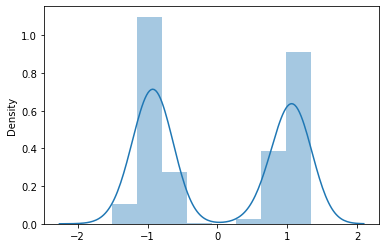

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


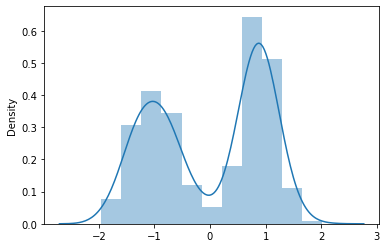

Test clean accuracy: 94.51
Test attack success rate: 99.92
16
tensor(0.7719, grad_fn=<SelectBackward0>) tensor(0.7417, grad_fn=<SelectBackward0>) tensor(1.1572, grad_fn=<SelectBackward0>)
tensor(0.8318, grad_fn=<SelectBackward0>) tensor(0.5924, grad_fn=<SelectBackward0>) tensor(1.3369, grad_fn=<SelectBackward0>)
tensor(0.8450, grad_fn=<SelectBackward0>) tensor(0.6049, grad_fn=<SelectBackward0>) tensor(0.9110, grad_fn=<SelectBackward0>)
tensor(0.8524, grad_fn=<SelectBackward0>) tensor(0.5964, grad_fn=<SelectBackward0>) tensor(1.2597, grad_fn=<SelectBackward0>)
tensor(0.8517, grad_fn=<SelectBackward0>) tensor(0.6055, grad_fn=<SelectBackward0>) tensor(0.5966, grad_fn=<SelectBackward0>)
tensor(0.8579, grad_fn=<SelectBackward0>) tensor(0.6162, grad_fn=<SelectBackward0>) tensor(1.0518, grad_fn=<SelectBackward0>)
tensor(0.8594, grad_fn=<SelectBackward0>) tensor(0.6117, grad_fn=<SelectBackward0>) tensor(0.6295, grad_fn=<SelectBackward0>)
tensor(0.8593, grad_fn=<SelectBackward0>) tensor(0.6236,

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


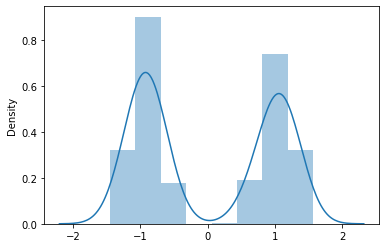

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


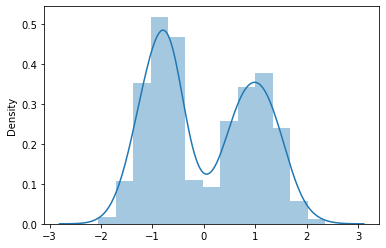

Test clean accuracy: 94.41
Test attack success rate: 99.97
19
tensor(0.7126, grad_fn=<SelectBackward0>) tensor(0.6821, grad_fn=<SelectBackward0>) tensor(1.2059, grad_fn=<SelectBackward0>)
tensor(0.8248, grad_fn=<SelectBackward0>) tensor(0.5606, grad_fn=<SelectBackward0>) tensor(1.2731, grad_fn=<SelectBackward0>)
tensor(0.8508, grad_fn=<SelectBackward0>) tensor(0.5596, grad_fn=<SelectBackward0>) tensor(1.4218, grad_fn=<SelectBackward0>)
tensor(0.8643, grad_fn=<SelectBackward0>) tensor(0.6056, grad_fn=<SelectBackward0>) tensor(0.7782, grad_fn=<SelectBackward0>)
tensor(0.8637, grad_fn=<SelectBackward0>) tensor(0.6117, grad_fn=<SelectBackward0>) tensor(0.3807, grad_fn=<SelectBackward0>)
tensor(0.8704, grad_fn=<SelectBackward0>) tensor(0.5931, grad_fn=<SelectBackward0>) tensor(1.1982, grad_fn=<SelectBackward0>)
tensor(0.8726, grad_fn=<SelectBackward0>) tensor(0.6020, grad_fn=<SelectBackward0>) tensor(0.9656, grad_fn=<SelectBackward0>)
tensor(0.8744, grad_fn=<SelectBackward0>) tensor(0.6013,

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


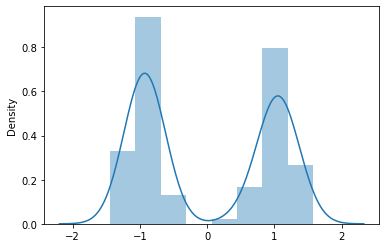

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


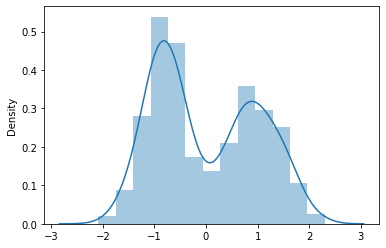

Test clean accuracy: 94.44
Test attack success rate: 99.97
25
tensor(0.6647, grad_fn=<SelectBackward0>) tensor(0.6628, grad_fn=<SelectBackward0>) tensor(1.2005, grad_fn=<SelectBackward0>)
tensor(0.8697, grad_fn=<SelectBackward0>) tensor(0.5546, grad_fn=<SelectBackward0>) tensor(1.3583, grad_fn=<SelectBackward0>)
tensor(0.8950, grad_fn=<SelectBackward0>) tensor(0.5474, grad_fn=<SelectBackward0>) tensor(0.0536, grad_fn=<SelectBackward0>)
tensor(0.9041, grad_fn=<SelectBackward0>) tensor(0.5441, grad_fn=<SelectBackward0>) tensor(1.0259, grad_fn=<SelectBackward0>)
tensor(0.9086, grad_fn=<SelectBackward0>) tensor(0.5492, grad_fn=<SelectBackward0>) tensor(0.6905, grad_fn=<SelectBackward0>)
tensor(0.9103, grad_fn=<SelectBackward0>) tensor(0.5337, grad_fn=<SelectBackward0>) tensor(0.6878, grad_fn=<SelectBackward0>)
tensor(0.9127, grad_fn=<SelectBackward0>) tensor(0.5399, grad_fn=<SelectBackward0>) tensor(0.4546, grad_fn=<SelectBackward0>)
tensor(0.9117, grad_fn=<SelectBackward0>) tensor(0.5209,

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


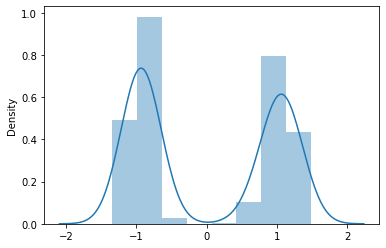

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


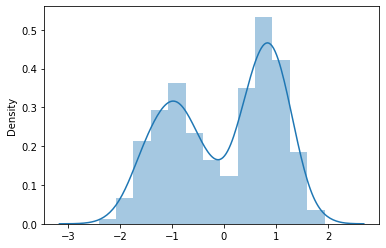

Test clean accuracy: 94.02
Test attack success rate: 99.91
28
tensor(0.5551, grad_fn=<SelectBackward0>) tensor(0.5366, grad_fn=<SelectBackward0>) tensor(1.0348, grad_fn=<SelectBackward0>)
tensor(0.8438, grad_fn=<SelectBackward0>) tensor(0.3815, grad_fn=<SelectBackward0>) tensor(1.1524, grad_fn=<SelectBackward0>)
tensor(0.8704, grad_fn=<SelectBackward0>) tensor(0.3667, grad_fn=<SelectBackward0>) tensor(0.8383, grad_fn=<SelectBackward0>)
tensor(0.8775, grad_fn=<SelectBackward0>) tensor(0.3816, grad_fn=<SelectBackward0>) tensor(1.0154, grad_fn=<SelectBackward0>)
tensor(0.8822, grad_fn=<SelectBackward0>) tensor(0.3676, grad_fn=<SelectBackward0>) tensor(0.4322, grad_fn=<SelectBackward0>)
tensor(0.8833, grad_fn=<SelectBackward0>) tensor(0.3612, grad_fn=<SelectBackward0>) tensor(0.4310, grad_fn=<SelectBackward0>)
tensor(0.8855, grad_fn=<SelectBackward0>) tensor(0.3448, grad_fn=<SelectBackward0>) tensor(0.7408, grad_fn=<SelectBackward0>)
tensor(0.8856, grad_fn=<SelectBackward0>) tensor(0.3428,

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


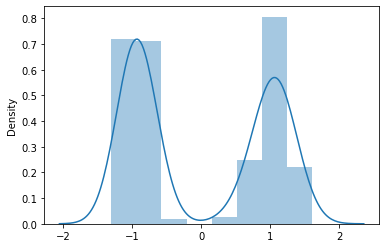

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


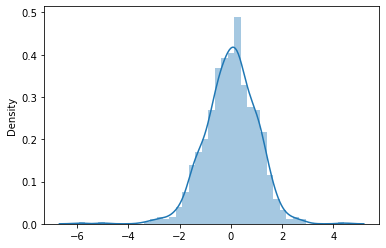

Test clean accuracy: 93.97
Test attack success rate: 99.87
31
tensor(0.7622, grad_fn=<SelectBackward0>) tensor(0.7568, grad_fn=<SelectBackward0>) tensor(1.1113, grad_fn=<SelectBackward0>)
tensor(0.8766, grad_fn=<SelectBackward0>) tensor(0.6742, grad_fn=<SelectBackward0>) tensor(1.0040, grad_fn=<SelectBackward0>)
tensor(0.8904, grad_fn=<SelectBackward0>) tensor(0.6535, grad_fn=<SelectBackward0>) tensor(0.8813, grad_fn=<SelectBackward0>)
tensor(0.9111, grad_fn=<SelectBackward0>) tensor(0.6865, grad_fn=<SelectBackward0>) tensor(1.0435, grad_fn=<SelectBackward0>)
tensor(0.9171, grad_fn=<SelectBackward0>) tensor(0.6729, grad_fn=<SelectBackward0>) tensor(0.6728, grad_fn=<SelectBackward0>)
tensor(0.9183, grad_fn=<SelectBackward0>) tensor(0.6708, grad_fn=<SelectBackward0>) tensor(0.7672, grad_fn=<SelectBackward0>)
tensor(0.9213, grad_fn=<SelectBackward0>) tensor(0.7003, grad_fn=<SelectBackward0>) tensor(0.7073, grad_fn=<SelectBackward0>)
tensor(0.9214, grad_fn=<SelectBackward0>) tensor(0.6869,

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


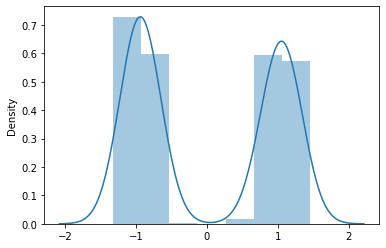

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


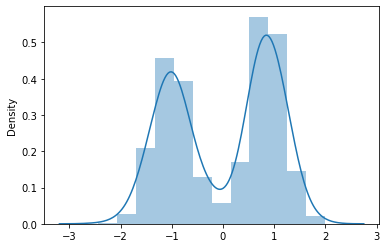

Test clean accuracy: 93.84
Test attack success rate: 99.83
35
tensor(0.5138, grad_fn=<SelectBackward0>) tensor(0.5024, grad_fn=<SelectBackward0>) tensor(0.8883, grad_fn=<SelectBackward0>)
tensor(0.8345, grad_fn=<SelectBackward0>) tensor(0.3793, grad_fn=<SelectBackward0>) tensor(0.9554, grad_fn=<SelectBackward0>)
tensor(0.8598, grad_fn=<SelectBackward0>) tensor(0.3817, grad_fn=<SelectBackward0>) tensor(0.2948, grad_fn=<SelectBackward0>)
tensor(0.8682, grad_fn=<SelectBackward0>) tensor(0.3857, grad_fn=<SelectBackward0>) tensor(0.0993, grad_fn=<SelectBackward0>)
tensor(0.8709, grad_fn=<SelectBackward0>) tensor(0.3818, grad_fn=<SelectBackward0>) tensor(0.0223, grad_fn=<SelectBackward0>)
tensor(0.8733, grad_fn=<SelectBackward0>) tensor(0.3646, grad_fn=<SelectBackward0>) tensor(0.6854, grad_fn=<SelectBackward0>)
tensor(0.8747, grad_fn=<SelectBackward0>) tensor(0.3576, grad_fn=<SelectBackward0>) tensor(0.8200, grad_fn=<SelectBackward0>)
tensor(0.8759, grad_fn=<SelectBackward0>) tensor(0.3462,

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


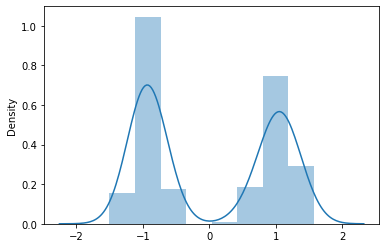

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


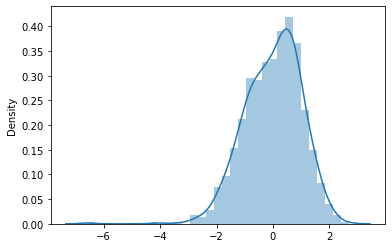

Test clean accuracy: 93.87
Test attack success rate: 99.83
38
tensor(0.5691, grad_fn=<SelectBackward0>) tensor(0.4773, grad_fn=<SelectBackward0>) tensor(1.1773, grad_fn=<SelectBackward0>)
tensor(0.6762, grad_fn=<SelectBackward0>) tensor(0.3759, grad_fn=<SelectBackward0>) tensor(0.8401, grad_fn=<SelectBackward0>)
tensor(0.6977, grad_fn=<SelectBackward0>) tensor(0.3673, grad_fn=<SelectBackward0>) tensor(0.4483, grad_fn=<SelectBackward0>)
tensor(0.7090, grad_fn=<SelectBackward0>) tensor(0.3609, grad_fn=<SelectBackward0>) tensor(1.1283, grad_fn=<SelectBackward0>)
tensor(0.7148, grad_fn=<SelectBackward0>) tensor(0.3658, grad_fn=<SelectBackward0>) tensor(1.0177, grad_fn=<SelectBackward0>)
tensor(0.7199, grad_fn=<SelectBackward0>) tensor(0.3664, grad_fn=<SelectBackward0>) tensor(1.1344, grad_fn=<SelectBackward0>)
tensor(0.7241, grad_fn=<SelectBackward0>) tensor(0.3510, grad_fn=<SelectBackward0>) tensor(0.7938, grad_fn=<SelectBackward0>)
tensor(0.7269, grad_fn=<SelectBackward0>) tensor(0.3341,

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


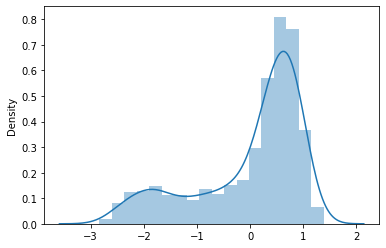

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


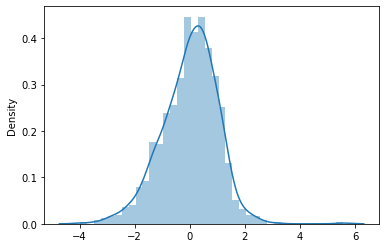

Test clean accuracy: 93.89
Test attack success rate: 99.74
44
tensor(0.5357, grad_fn=<SelectBackward0>) tensor(0.5269, grad_fn=<SelectBackward0>) tensor(0.9652, grad_fn=<SelectBackward0>)
tensor(0.8923, grad_fn=<SelectBackward0>) tensor(0.4052, grad_fn=<SelectBackward0>) tensor(1.2887, grad_fn=<SelectBackward0>)
tensor(0.9085, grad_fn=<SelectBackward0>) tensor(0.3921, grad_fn=<SelectBackward0>) tensor(0.7083, grad_fn=<SelectBackward0>)
tensor(0.9191, grad_fn=<SelectBackward0>) tensor(0.3911, grad_fn=<SelectBackward0>) tensor(0.6913, grad_fn=<SelectBackward0>)
tensor(0.9231, grad_fn=<SelectBackward0>) tensor(0.3697, grad_fn=<SelectBackward0>) tensor(0.4752, grad_fn=<SelectBackward0>)
tensor(0.9235, grad_fn=<SelectBackward0>) tensor(0.3561, grad_fn=<SelectBackward0>) tensor(0.0018, grad_fn=<SelectBackward0>)
tensor(0.9259, grad_fn=<SelectBackward0>) tensor(0.3582, grad_fn=<SelectBackward0>) tensor(0.4274, grad_fn=<SelectBackward0>)
tensor(0.9276, grad_fn=<SelectBackward0>) tensor(0.3366,

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


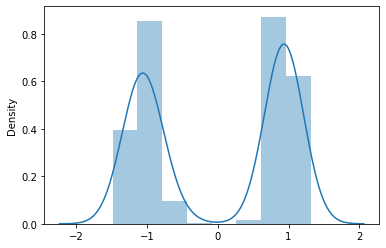

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


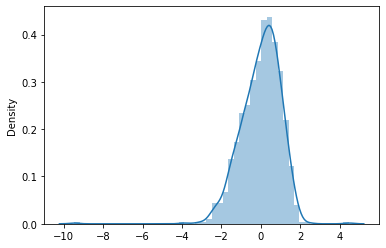

Test clean accuracy: 93.75
Test attack success rate: 96.36
47
tensor(0.5519, grad_fn=<SelectBackward0>) tensor(0.5418, grad_fn=<SelectBackward0>) tensor(0.7075, grad_fn=<SelectBackward0>)
tensor(0.8689, grad_fn=<SelectBackward0>) tensor(0.4673, grad_fn=<SelectBackward0>) tensor(0.4484, grad_fn=<SelectBackward0>)
tensor(0.9023, grad_fn=<SelectBackward0>) tensor(0.4451, grad_fn=<SelectBackward0>) tensor(0.7349, grad_fn=<SelectBackward0>)
tensor(0.9078, grad_fn=<SelectBackward0>) tensor(0.4230, grad_fn=<SelectBackward0>) tensor(0.8375, grad_fn=<SelectBackward0>)
tensor(0.9161, grad_fn=<SelectBackward0>) tensor(0.4272, grad_fn=<SelectBackward0>) tensor(0.4191, grad_fn=<SelectBackward0>)
tensor(0.9165, grad_fn=<SelectBackward0>) tensor(0.4072, grad_fn=<SelectBackward0>) tensor(0.7442, grad_fn=<SelectBackward0>)
tensor(0.9178, grad_fn=<SelectBackward0>) tensor(0.4140, grad_fn=<SelectBackward0>) tensor(0.7810, grad_fn=<SelectBackward0>)
tensor(0.9197, grad_fn=<SelectBackward0>) tensor(0.3765,

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


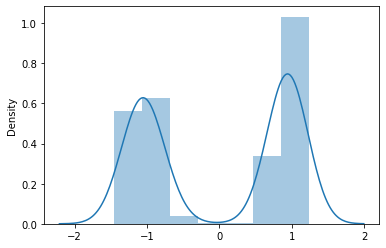

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


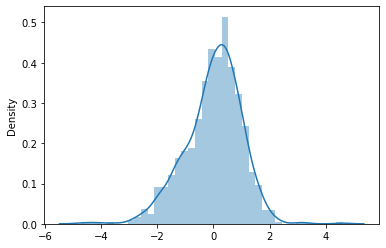

Test clean accuracy: 93.45
Test attack success rate: 79.01
50
tensor(0.5981, grad_fn=<SelectBackward0>) tensor(0.5908, grad_fn=<SelectBackward0>) tensor(0.4894, grad_fn=<SelectBackward0>)
tensor(0.8671, grad_fn=<SelectBackward0>) tensor(0.4941, grad_fn=<SelectBackward0>) tensor(0.3235, grad_fn=<SelectBackward0>)
tensor(0.8966, grad_fn=<SelectBackward0>) tensor(0.4771, grad_fn=<SelectBackward0>) tensor(0.5443, grad_fn=<SelectBackward0>)
tensor(0.9076, grad_fn=<SelectBackward0>) tensor(0.4608, grad_fn=<SelectBackward0>) tensor(0.6477, grad_fn=<SelectBackward0>)
tensor(0.9104, grad_fn=<SelectBackward0>) tensor(0.4816, grad_fn=<SelectBackward0>) tensor(0.4813, grad_fn=<SelectBackward0>)
tensor(0.9145, grad_fn=<SelectBackward0>) tensor(0.4792, grad_fn=<SelectBackward0>) tensor(1.1877, grad_fn=<SelectBackward0>)
tensor(0.9166, grad_fn=<SelectBackward0>) tensor(0.5028, grad_fn=<SelectBackward0>) tensor(0.9302, grad_fn=<SelectBackward0>)
tensor(0.9184, grad_fn=<SelectBackward0>) tensor(0.4978,

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


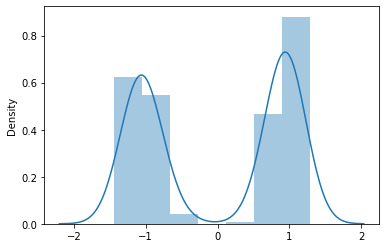

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


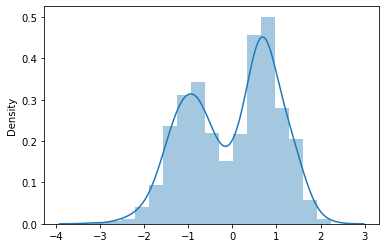

Test clean accuracy: 93.41
Test attack success rate: 77.07
54
tensor(0.5740, grad_fn=<SelectBackward0>) tensor(0.5703, grad_fn=<SelectBackward0>) tensor(0.6639, grad_fn=<SelectBackward0>)
tensor(0.8303, grad_fn=<SelectBackward0>) tensor(0.4843, grad_fn=<SelectBackward0>) tensor(0.6867, grad_fn=<SelectBackward0>)
tensor(0.8657, grad_fn=<SelectBackward0>) tensor(0.4831, grad_fn=<SelectBackward0>) tensor(0.2501, grad_fn=<SelectBackward0>)
tensor(0.8719, grad_fn=<SelectBackward0>) tensor(0.4550, grad_fn=<SelectBackward0>) tensor(1.1491, grad_fn=<SelectBackward0>)
tensor(0.8764, grad_fn=<SelectBackward0>) tensor(0.4450, grad_fn=<SelectBackward0>) tensor(1.0382, grad_fn=<SelectBackward0>)
tensor(0.8795, grad_fn=<SelectBackward0>) tensor(0.4449, grad_fn=<SelectBackward0>) tensor(0.5438, grad_fn=<SelectBackward0>)
tensor(0.8809, grad_fn=<SelectBackward0>) tensor(0.4453, grad_fn=<SelectBackward0>) tensor(0.5087, grad_fn=<SelectBackward0>)
tensor(0.8816, grad_fn=<SelectBackward0>) tensor(0.4200,

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


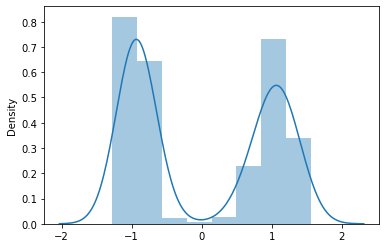

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


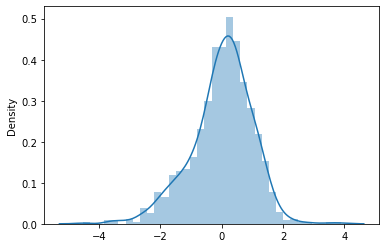

Test clean accuracy: 93.46
Test attack success rate: 72.87
57
tensor(0.5566, grad_fn=<SelectBackward0>) tensor(0.5562, grad_fn=<SelectBackward0>) tensor(0.6380, grad_fn=<SelectBackward0>)
tensor(0.7254, grad_fn=<SelectBackward0>) tensor(0.4904, grad_fn=<SelectBackward0>) tensor(0.8511, grad_fn=<SelectBackward0>)
tensor(0.7650, grad_fn=<SelectBackward0>) tensor(0.4980, grad_fn=<SelectBackward0>) tensor(0.9966, grad_fn=<SelectBackward0>)
tensor(0.7873, grad_fn=<SelectBackward0>) tensor(0.4697, grad_fn=<SelectBackward0>) tensor(0.7395, grad_fn=<SelectBackward0>)
tensor(0.8001, grad_fn=<SelectBackward0>) tensor(0.4581, grad_fn=<SelectBackward0>) tensor(0.3137, grad_fn=<SelectBackward0>)
tensor(0.7536, grad_fn=<SelectBackward0>) tensor(0.4348, grad_fn=<SelectBackward0>) tensor(0.9742, grad_fn=<SelectBackward0>)
tensor(0.8025, grad_fn=<SelectBackward0>) tensor(0.4638, grad_fn=<SelectBackward0>) tensor(0.5741, grad_fn=<SelectBackward0>)
tensor(0.7781, grad_fn=<SelectBackward0>) tensor(0.4279,

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


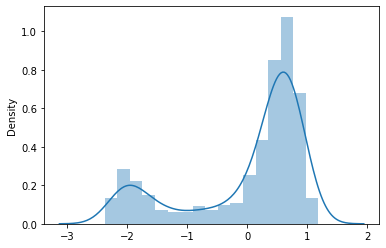

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


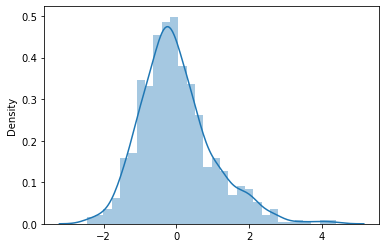

Test clean accuracy: 93.47
Test attack success rate: 71.79
63
tensor(0.5695, grad_fn=<SelectBackward0>) tensor(0.5551, grad_fn=<SelectBackward0>) tensor(0.7444, grad_fn=<SelectBackward0>)
tensor(0.8704, grad_fn=<SelectBackward0>) tensor(0.4912, grad_fn=<SelectBackward0>) tensor(0.6960, grad_fn=<SelectBackward0>)
tensor(0.9126, grad_fn=<SelectBackward0>) tensor(0.4879, grad_fn=<SelectBackward0>) tensor(0.7032, grad_fn=<SelectBackward0>)
tensor(0.9277, grad_fn=<SelectBackward0>) tensor(0.4751, grad_fn=<SelectBackward0>) tensor(0.7022, grad_fn=<SelectBackward0>)
tensor(0.9348, grad_fn=<SelectBackward0>) tensor(0.4536, grad_fn=<SelectBackward0>) tensor(0.9506, grad_fn=<SelectBackward0>)
tensor(0.9394, grad_fn=<SelectBackward0>) tensor(0.4337, grad_fn=<SelectBackward0>) tensor(0.6806, grad_fn=<SelectBackward0>)
tensor(0.9433, grad_fn=<SelectBackward0>) tensor(0.4284, grad_fn=<SelectBackward0>) tensor(0.8554, grad_fn=<SelectBackward0>)
tensor(0.9450, grad_fn=<SelectBackward0>) tensor(0.4156,

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


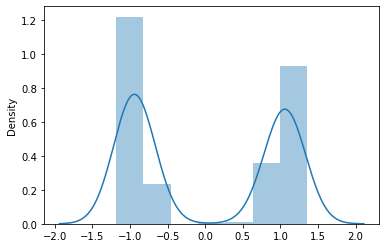

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


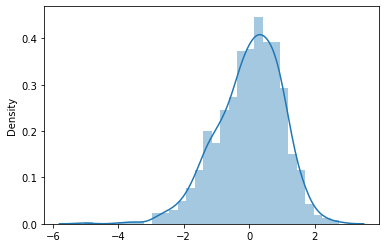

Test clean accuracy: 93.49
Test attack success rate: 66.11
66
tensor(0.6100, grad_fn=<SelectBackward0>) tensor(0.6085, grad_fn=<SelectBackward0>) tensor(0.9838, grad_fn=<SelectBackward0>)
tensor(0.7855, grad_fn=<SelectBackward0>) tensor(0.5366, grad_fn=<SelectBackward0>) tensor(0.8405, grad_fn=<SelectBackward0>)
tensor(0.8230, grad_fn=<SelectBackward0>) tensor(0.5392, grad_fn=<SelectBackward0>) tensor(0.9085, grad_fn=<SelectBackward0>)
tensor(0.7859, grad_fn=<SelectBackward0>) tensor(0.5188, grad_fn=<SelectBackward0>) tensor(1.2210, grad_fn=<SelectBackward0>)
tensor(0.8239, grad_fn=<SelectBackward0>) tensor(0.5334, grad_fn=<SelectBackward0>) tensor(0.9684, grad_fn=<SelectBackward0>)
tensor(0.8518, grad_fn=<SelectBackward0>) tensor(0.5217, grad_fn=<SelectBackward0>) tensor(0.7009, grad_fn=<SelectBackward0>)
tensor(0.7804, grad_fn=<SelectBackward0>) tensor(0.5068, grad_fn=<SelectBackward0>) tensor(0.8627, grad_fn=<SelectBackward0>)
tensor(0.8307, grad_fn=<SelectBackward0>) tensor(0.5239,

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


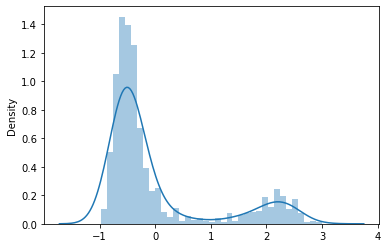

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


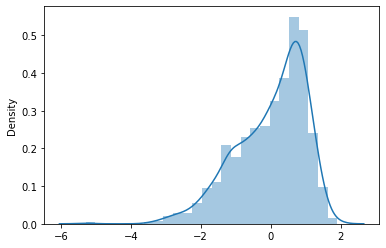

Test clean accuracy: 93.49
Test attack success rate: 66.07
69
tensor(0.4934, grad_fn=<SelectBackward0>) tensor(0.4740, grad_fn=<SelectBackward0>) tensor(0.8230, grad_fn=<SelectBackward0>)
tensor(0.8435, grad_fn=<SelectBackward0>) tensor(0.3917, grad_fn=<SelectBackward0>) tensor(0.7716, grad_fn=<SelectBackward0>)
tensor(0.8879, grad_fn=<SelectBackward0>) tensor(0.3896, grad_fn=<SelectBackward0>) tensor(0.4090, grad_fn=<SelectBackward0>)
tensor(0.9053, grad_fn=<SelectBackward0>) tensor(0.4018, grad_fn=<SelectBackward0>) tensor(0.6182, grad_fn=<SelectBackward0>)
tensor(0.9159, grad_fn=<SelectBackward0>) tensor(0.3714, grad_fn=<SelectBackward0>) tensor(0.6465, grad_fn=<SelectBackward0>)
tensor(0.9223, grad_fn=<SelectBackward0>) tensor(0.3712, grad_fn=<SelectBackward0>) tensor(0.6650, grad_fn=<SelectBackward0>)
tensor(0.9263, grad_fn=<SelectBackward0>) tensor(0.3757, grad_fn=<SelectBackward0>) tensor(0.0695, grad_fn=<SelectBackward0>)
tensor(0.9287, grad_fn=<SelectBackward0>) tensor(0.3459,

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


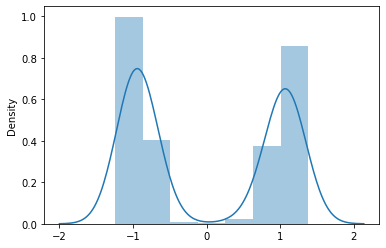

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


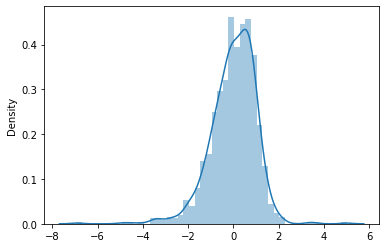

Test clean accuracy: 93.49
Test attack success rate: 65.04
73
tensor(0.6118, grad_fn=<SelectBackward0>) tensor(0.5899, grad_fn=<SelectBackward0>) tensor(0.9250, grad_fn=<SelectBackward0>)
tensor(0.7772, grad_fn=<SelectBackward0>) tensor(0.5216, grad_fn=<SelectBackward0>) tensor(0.7068, grad_fn=<SelectBackward0>)
tensor(0.8068, grad_fn=<SelectBackward0>) tensor(0.5177, grad_fn=<SelectBackward0>) tensor(1.1948, grad_fn=<SelectBackward0>)
tensor(0.8189, grad_fn=<SelectBackward0>) tensor(0.5045, grad_fn=<SelectBackward0>) tensor(0.7017, grad_fn=<SelectBackward0>)
tensor(0.8124, grad_fn=<SelectBackward0>) tensor(0.5197, grad_fn=<SelectBackward0>) tensor(0.4488, grad_fn=<SelectBackward0>)
tensor(0.8388, grad_fn=<SelectBackward0>) tensor(0.5058, grad_fn=<SelectBackward0>) tensor(0.8450, grad_fn=<SelectBackward0>)
tensor(0.8048, grad_fn=<SelectBackward0>) tensor(0.5062, grad_fn=<SelectBackward0>) tensor(0.7024, grad_fn=<SelectBackward0>)
tensor(0.8013, grad_fn=<SelectBackward0>) tensor(0.5018,

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


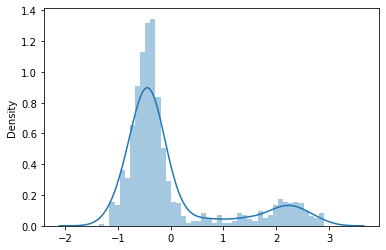

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


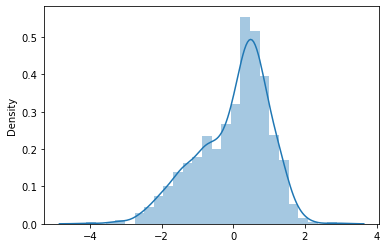

Test clean accuracy: 93.47
Test attack success rate: 65.48
76
tensor(0.5017, grad_fn=<SelectBackward0>) tensor(0.4793, grad_fn=<SelectBackward0>) tensor(1.0470, grad_fn=<SelectBackward0>)
tensor(0.6331, grad_fn=<SelectBackward0>) tensor(0.3870, grad_fn=<SelectBackward0>) tensor(1.2900, grad_fn=<SelectBackward0>)
tensor(0.6926, grad_fn=<SelectBackward0>) tensor(0.3745, grad_fn=<SelectBackward0>) tensor(0.8257, grad_fn=<SelectBackward0>)
tensor(0.6665, grad_fn=<SelectBackward0>) tensor(0.3746, grad_fn=<SelectBackward0>) tensor(0.7047, grad_fn=<SelectBackward0>)
tensor(0.7048, grad_fn=<SelectBackward0>) tensor(0.3725, grad_fn=<SelectBackward0>) tensor(0.9033, grad_fn=<SelectBackward0>)
tensor(0.6976, grad_fn=<SelectBackward0>) tensor(0.3630, grad_fn=<SelectBackward0>) tensor(0.7259, grad_fn=<SelectBackward0>)
tensor(0.6875, grad_fn=<SelectBackward0>) tensor(0.3679, grad_fn=<SelectBackward0>) tensor(0.7219, grad_fn=<SelectBackward0>)
tensor(0.7257, grad_fn=<SelectBackward0>) tensor(0.3714,

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


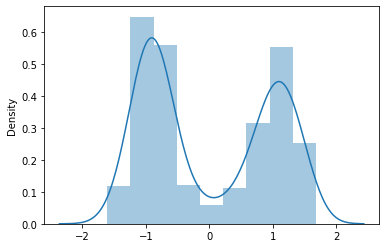

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


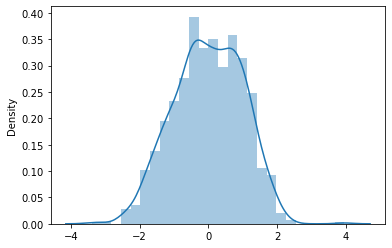

Test clean accuracy: 93.47
Test attack success rate: 65.50


In [97]:
ckpt = load_checkpoint(args)
state_dict, trigger = ckpt['state_dict'], ckpt['trigger']
net = get_model(args.model, num_classes).to(args.device)
net.load_state_dict(state_dict)

for i, (name, m) in enumerate(net.named_modules()):
    if isinstance(m, nn.Conv2d):
        print(i)
        with torch.no_grad():
            net(images[:1000].to(args.device))
        n, c, w, h = m.feat.shape
        feat = m.feat.detach().cpu().reshape(n, c, -1).max(-1)[0]
        orth_mat = geoopt.ManifoldParameter(manifold.random(m.weight.shape[0], m.weight.shape[0]))
        opt = RiemannianAdam([orth_mat], lr=1e-3)
        for i in range(20000):
            out = feat.matmul(orth_mat)
            out = (out - out.mean(0)) / out.std(0)

            skws = skewness(out)
            kurt = kurtosis(out)
            sbc = (skws**2+1)/kurt

            index = sbc.topk(2)[1]

            entropy = kernel_entropy(out[index], n_bars=20, bw=0.1)

            if i % 1000 == 0:
                print(sbc[index[0]], sbc[index[1]], entropy[index[0]])
#                 print(sbc[index])
            loss = -sbc[index[0]] + sbc[index[1]] #+ entropy[index[0]]
            loss.backward()

#             print(max_sbc, entropy)
#             print(out[:, index].mean(), out[:, index].std())
            opt.step()


        sns.distplot(out[:, index[0]].cpu().detach())
        plt.show()
        sns.distplot(out[:, index[1]].cpu().detach())
        plt.show()

        weight = m.weight.cpu()
        orth_mat.detach_()
        orth_mat[:, index[0]] = 0
        new_weight = torch.einsum('oihw, ok-> kihw', weight, orth_mat)
        new_weight = torch.einsum('kihw, ko-> oihw', new_weight, orth_mat.T)

        state_dict = m.state_dict()
        state_dict['weight'] = new_weight
        m.load_state_dict(state_dict)
        acc, asr = val(net, test_clean_loader), val(net, test_poisoned_loader)
        print('Test clean accuracy: %.2f' % acc)
        print('Test attack success rate: %.2f' % asr)

Checkpoint loaded from ./ckpt/resnet18_blended_32_0.1_0.pth
2
8
tensor([0.6789], grad_fn=<IndexBackward0>) tensor(0.6590, grad_fn=<SelectBackward0>) tensor([0.7808], grad_fn=<IndexBackward0>)
tensor([0.7288], grad_fn=<IndexBackward0>) tensor(0.6330, grad_fn=<SelectBackward0>) tensor([0.7406], grad_fn=<IndexBackward0>)
tensor([0.7748], grad_fn=<IndexBackward0>) tensor(0.6224, grad_fn=<SelectBackward0>) tensor([0.6875], grad_fn=<IndexBackward0>)
tensor([0.7758], grad_fn=<IndexBackward0>) tensor(0.6102, grad_fn=<SelectBackward0>) tensor([0.7090], grad_fn=<IndexBackward0>)
tensor([0.7696], grad_fn=<IndexBackward0>) tensor(0.5891, grad_fn=<SelectBackward0>) tensor([0.6972], grad_fn=<IndexBackward0>)
tensor([0.7664], grad_fn=<IndexBackward0>) tensor(0.5784, grad_fn=<SelectBackward0>) tensor([0.7370], grad_fn=<IndexBackward0>)
tensor([0.7662], grad_fn=<IndexBackward0>) tensor(0.5563, grad_fn=<SelectBackward0>) tensor([0.6910], grad_fn=<IndexBackward0>)
tensor([0.7663], grad_fn=<IndexBackward0

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


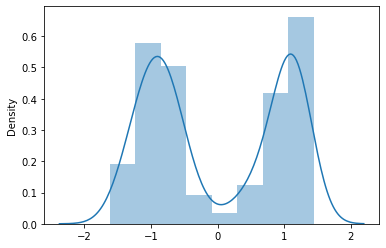

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


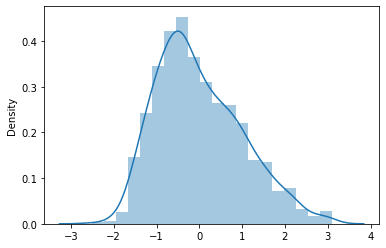

Test clean accuracy: 94.33
Test attack success rate: 99.91
11
tensor([0.7058], grad_fn=<IndexBackward0>) tensor(0.7037, grad_fn=<SelectBackward0>) tensor([0.1209], grad_fn=<IndexBackward0>)
tensor([0.7494], grad_fn=<IndexBackward0>) tensor(0.6792, grad_fn=<SelectBackward0>) tensor([0.1953], grad_fn=<IndexBackward0>)
tensor([0.7676], grad_fn=<IndexBackward0>) tensor(0.6652, grad_fn=<SelectBackward0>) tensor([0.5053], grad_fn=<IndexBackward0>)
tensor([0.7829], grad_fn=<IndexBackward0>) tensor(0.6411, grad_fn=<SelectBackward0>) tensor([0.2658], grad_fn=<IndexBackward0>)
tensor([0.7883], grad_fn=<IndexBackward0>) tensor(0.6242, grad_fn=<SelectBackward0>) tensor([0.6936], grad_fn=<IndexBackward0>)
tensor([0.7909], grad_fn=<IndexBackward0>) tensor(0.5975, grad_fn=<SelectBackward0>) tensor([0.3562], grad_fn=<IndexBackward0>)
tensor([0.7859], grad_fn=<IndexBackward0>) tensor(0.5755, grad_fn=<SelectBackward0>) tensor([0.5157], grad_fn=<IndexBackward0>)
tensor([0.7889], grad_fn=<IndexBackward0>)

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


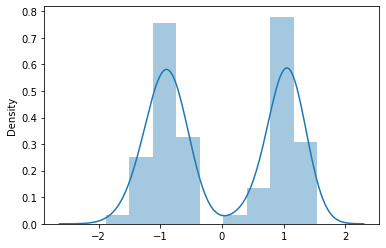

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


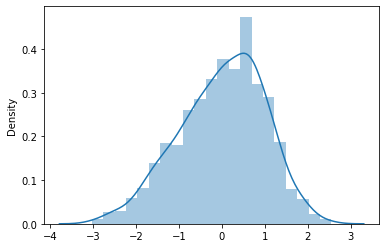

Test clean accuracy: 93.98
Test attack success rate: 99.96
16
tensor([0.8026], grad_fn=<IndexBackward0>) tensor(0.7256, grad_fn=<SelectBackward0>) tensor([0.7461], grad_fn=<IndexBackward0>)
tensor([0.7967], grad_fn=<IndexBackward0>) tensor(0.6912, grad_fn=<SelectBackward0>) tensor([0.7128], grad_fn=<IndexBackward0>)
tensor([0.8195], grad_fn=<IndexBackward0>) tensor(0.6540, grad_fn=<SelectBackward0>) tensor([0.7545], grad_fn=<IndexBackward0>)
tensor([0.8241], grad_fn=<IndexBackward0>) tensor(0.6509, grad_fn=<SelectBackward0>) tensor([0.6744], grad_fn=<IndexBackward0>)
tensor([0.8253], grad_fn=<IndexBackward0>) tensor(0.6534, grad_fn=<SelectBackward0>) tensor([0.7404], grad_fn=<IndexBackward0>)
tensor([0.8387], grad_fn=<IndexBackward0>) tensor(0.6432, grad_fn=<SelectBackward0>) tensor([0.6823], grad_fn=<IndexBackward0>)
tensor([0.8471], grad_fn=<IndexBackward0>) tensor(0.6257, grad_fn=<SelectBackward0>) tensor([0.7681], grad_fn=<IndexBackward0>)
tensor([0.8505], grad_fn=<IndexBackward0>)

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


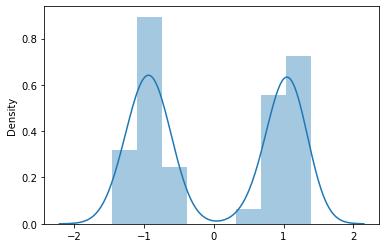

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


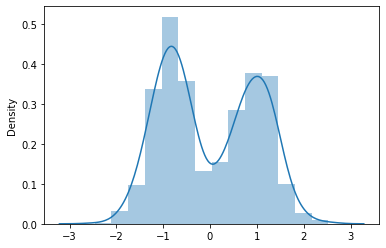

Test clean accuracy: 93.61
Test attack success rate: 99.98
19
tensor([0.6499], grad_fn=<IndexBackward0>) tensor(0.6265, grad_fn=<SelectBackward0>) tensor([0.7833], grad_fn=<IndexBackward0>)
tensor([0.7230], grad_fn=<IndexBackward0>) tensor(0.5636, grad_fn=<SelectBackward0>) tensor([0.6715], grad_fn=<IndexBackward0>)
tensor([0.7702], grad_fn=<IndexBackward0>) tensor(0.5404, grad_fn=<SelectBackward0>) tensor([0.7070], grad_fn=<IndexBackward0>)
tensor([0.7875], grad_fn=<IndexBackward0>) tensor(0.5262, grad_fn=<SelectBackward0>) tensor([0.7322], grad_fn=<IndexBackward0>)
tensor([0.7953], grad_fn=<IndexBackward0>) tensor(0.5080, grad_fn=<SelectBackward0>) tensor([0.7055], grad_fn=<IndexBackward0>)
tensor([0.8080], grad_fn=<IndexBackward0>) tensor(0.4892, grad_fn=<SelectBackward0>) tensor([0.6967], grad_fn=<IndexBackward0>)
tensor([0.8159], grad_fn=<IndexBackward0>) tensor(0.4818, grad_fn=<SelectBackward0>) tensor([0.7418], grad_fn=<IndexBackward0>)
tensor([0.8189], grad_fn=<IndexBackward0>)

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


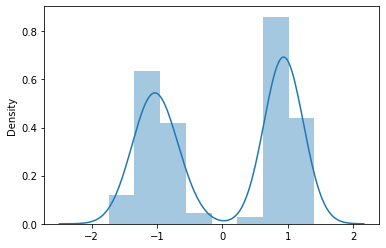

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


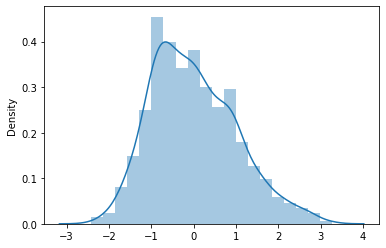

Test clean accuracy: 93.29
Test attack success rate: 99.98
25
tensor([0.7128], grad_fn=<IndexBackward0>) tensor(0.7019, grad_fn=<SelectBackward0>) tensor([0.5001], grad_fn=<IndexBackward0>)
tensor([0.7600], grad_fn=<IndexBackward0>) tensor(0.6936, grad_fn=<SelectBackward0>) tensor([0.6991], grad_fn=<IndexBackward0>)
tensor([0.7985], grad_fn=<IndexBackward0>) tensor(0.6828, grad_fn=<SelectBackward0>) tensor([0.3666], grad_fn=<IndexBackward0>)
tensor([0.8236], grad_fn=<IndexBackward0>) tensor(0.6640, grad_fn=<SelectBackward0>) tensor([0.6062], grad_fn=<IndexBackward0>)
tensor([0.8470], grad_fn=<IndexBackward0>) tensor(0.6446, grad_fn=<SelectBackward0>) tensor([0.6228], grad_fn=<IndexBackward0>)
tensor([0.8535], grad_fn=<IndexBackward0>) tensor(0.6211, grad_fn=<SelectBackward0>) tensor([0.6414], grad_fn=<IndexBackward0>)
tensor([0.8555], grad_fn=<IndexBackward0>) tensor(0.6105, grad_fn=<SelectBackward0>) tensor([0.7315], grad_fn=<IndexBackward0>)
tensor([0.8545], grad_fn=<IndexBackward0>)

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


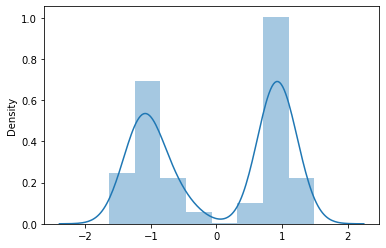

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


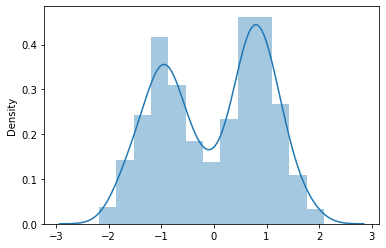

Test clean accuracy: 93.33
Test attack success rate: 99.98
28
tensor([0.6410], grad_fn=<IndexBackward0>) tensor(0.6111, grad_fn=<SelectBackward0>) tensor([0.1280], grad_fn=<IndexBackward0>)
tensor([0.6378], grad_fn=<IndexBackward0>) tensor(0.5856, grad_fn=<SelectBackward0>) tensor([0.2818], grad_fn=<IndexBackward0>)
tensor([0.5933], grad_fn=<IndexBackward0>) tensor(0.5772, grad_fn=<SelectBackward0>) tensor([0.3842], grad_fn=<IndexBackward0>)
tensor([0.6542], grad_fn=<IndexBackward0>) tensor(0.5702, grad_fn=<SelectBackward0>) tensor([0.3645], grad_fn=<IndexBackward0>)
tensor([0.7051], grad_fn=<IndexBackward0>) tensor(0.5571, grad_fn=<SelectBackward0>) tensor([0.6472], grad_fn=<IndexBackward0>)
tensor([0.7424], grad_fn=<IndexBackward0>) tensor(0.5424, grad_fn=<SelectBackward0>) tensor([0.5859], grad_fn=<IndexBackward0>)
tensor([0.7725], grad_fn=<IndexBackward0>) tensor(0.5372, grad_fn=<SelectBackward0>) tensor([0.7066], grad_fn=<IndexBackward0>)
tensor([0.7946], grad_fn=<IndexBackward0>)

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


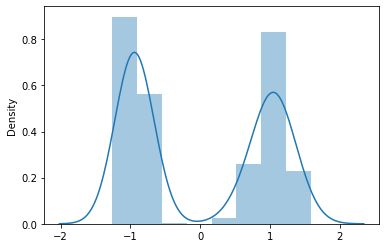

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


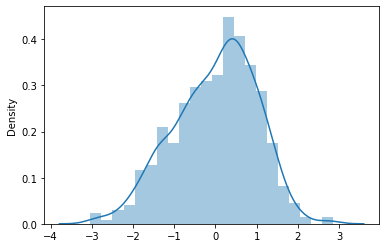

Test clean accuracy: 93.28
Test attack success rate: 99.62
31
tensor([0.7964], grad_fn=<IndexBackward0>) tensor(0.7765, grad_fn=<SelectBackward0>) tensor([0.7106], grad_fn=<IndexBackward0>)
tensor([0.8125], grad_fn=<IndexBackward0>) tensor(0.7420, grad_fn=<SelectBackward0>) tensor([0.7003], grad_fn=<IndexBackward0>)
tensor([0.8252], grad_fn=<IndexBackward0>) tensor(0.6991, grad_fn=<SelectBackward0>) tensor([0.7015], grad_fn=<IndexBackward0>)
tensor([0.8403], grad_fn=<IndexBackward0>) tensor(0.6705, grad_fn=<SelectBackward0>) tensor([0.6704], grad_fn=<IndexBackward0>)
tensor([0.8511], grad_fn=<IndexBackward0>) tensor(0.6276, grad_fn=<SelectBackward0>) tensor([0.7066], grad_fn=<IndexBackward0>)
tensor([0.8569], grad_fn=<IndexBackward0>) tensor(0.6099, grad_fn=<SelectBackward0>) tensor([0.6782], grad_fn=<IndexBackward0>)
tensor([0.8599], grad_fn=<IndexBackward0>) tensor(0.6083, grad_fn=<SelectBackward0>) tensor([0.6774], grad_fn=<IndexBackward0>)
tensor([0.8627], grad_fn=<IndexBackward0>)

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


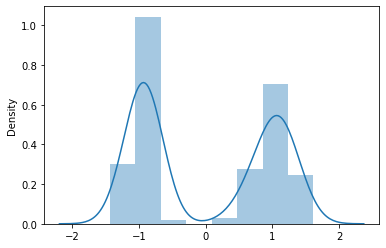

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


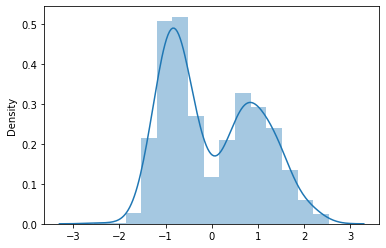

Test clean accuracy: 92.49
Test attack success rate: 54.20
35
tensor([0.6787], grad_fn=<IndexBackward0>) tensor(0.5853, grad_fn=<SelectBackward0>) tensor([0.1350], grad_fn=<IndexBackward0>)
tensor([0.7163], grad_fn=<IndexBackward0>) tensor(0.5574, grad_fn=<SelectBackward0>) tensor([0.2159], grad_fn=<IndexBackward0>)
tensor([0.7043], grad_fn=<IndexBackward0>) tensor(0.5557, grad_fn=<SelectBackward0>) tensor([0.6920], grad_fn=<IndexBackward0>)
tensor([0.6632], grad_fn=<IndexBackward0>) tensor(0.5570, grad_fn=<SelectBackward0>) tensor([0.5600], grad_fn=<IndexBackward0>)
tensor([0.5728], grad_fn=<IndexBackward0>) tensor(0.5531, grad_fn=<SelectBackward0>) tensor([0.5995], grad_fn=<IndexBackward0>)
tensor([0.5675], grad_fn=<IndexBackward0>) tensor(0.5517, grad_fn=<SelectBackward0>) tensor([0.4613], grad_fn=<IndexBackward0>)
tensor([0.6093], grad_fn=<IndexBackward0>) tensor(0.5522, grad_fn=<SelectBackward0>) tensor([0.6031], grad_fn=<IndexBackward0>)
tensor([0.6477], grad_fn=<IndexBackward0>)

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


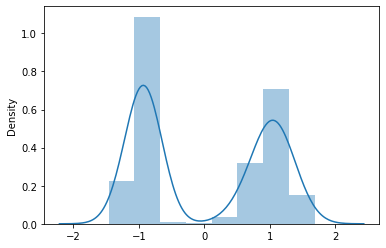

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


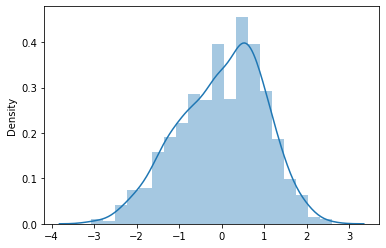

Test clean accuracy: 92.51
Test attack success rate: 39.61
38
tensor([0.5487], grad_fn=<IndexBackward0>) tensor(0.5487, grad_fn=<SelectBackward0>) tensor([0.6846], grad_fn=<IndexBackward0>)
tensor([0.5628], grad_fn=<IndexBackward0>) tensor(0.5341, grad_fn=<SelectBackward0>) tensor([0.6146], grad_fn=<IndexBackward0>)
tensor([0.5814], grad_fn=<IndexBackward0>) tensor(0.5255, grad_fn=<SelectBackward0>) tensor([0.5538], grad_fn=<IndexBackward0>)
tensor([0.5911], grad_fn=<IndexBackward0>) tensor(0.5156, grad_fn=<SelectBackward0>) tensor([0.3370], grad_fn=<IndexBackward0>)
tensor([0.5898], grad_fn=<IndexBackward0>) tensor(0.5100, grad_fn=<SelectBackward0>) tensor([0.4373], grad_fn=<IndexBackward0>)
tensor([0.5766], grad_fn=<IndexBackward0>) tensor(0.5062, grad_fn=<SelectBackward0>) tensor([0.7689], grad_fn=<IndexBackward0>)
tensor([0.5625], grad_fn=<IndexBackward0>) tensor(0.5008, grad_fn=<SelectBackward0>) tensor([0.6865], grad_fn=<IndexBackward0>)
tensor([0.5453], grad_fn=<IndexBackward0>)

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


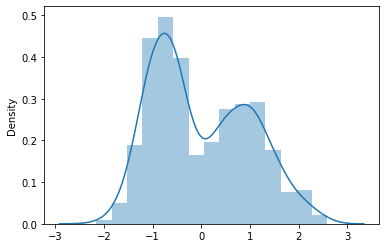

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


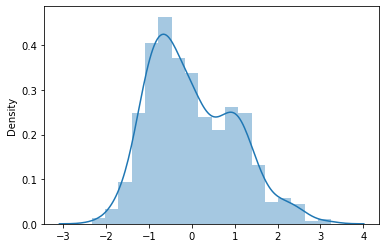

Test clean accuracy: 92.43
Test attack success rate: 40.31
44
tensor([0.6338], grad_fn=<IndexBackward0>) tensor(0.5900, grad_fn=<SelectBackward0>) tensor([0.6406], grad_fn=<IndexBackward0>)
tensor([0.5884], grad_fn=<IndexBackward0>) tensor(0.5827, grad_fn=<SelectBackward0>) tensor([0.0164], grad_fn=<IndexBackward0>)
tensor([0.6001], grad_fn=<IndexBackward0>) tensor(0.5659, grad_fn=<SelectBackward0>) tensor([0.0119], grad_fn=<IndexBackward0>)
tensor([0.6323], grad_fn=<IndexBackward0>) tensor(0.5389, grad_fn=<SelectBackward0>) tensor([0.0882], grad_fn=<IndexBackward0>)
tensor([0.6777], grad_fn=<IndexBackward0>) tensor(0.5281, grad_fn=<SelectBackward0>) tensor([0.0149], grad_fn=<IndexBackward0>)
tensor([0.7046], grad_fn=<IndexBackward0>) tensor(0.5242, grad_fn=<SelectBackward0>) tensor([0.6922], grad_fn=<IndexBackward0>)
tensor([0.7126], grad_fn=<IndexBackward0>) tensor(0.5217, grad_fn=<SelectBackward0>) tensor([0.0080], grad_fn=<IndexBackward0>)
tensor([0.6977], grad_fn=<IndexBackward0>)

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


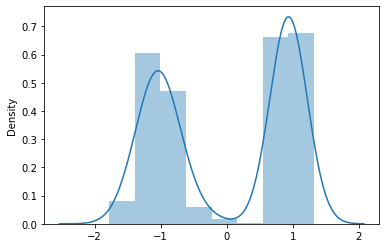

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


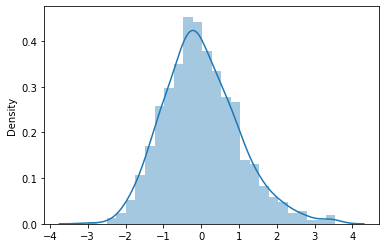

Test clean accuracy: 92.22
Test attack success rate: 40.07
47
tensor([0.5561], grad_fn=<IndexBackward0>) tensor(0.5558, grad_fn=<SelectBackward0>) tensor([0.1549], grad_fn=<IndexBackward0>)
tensor([0.5669], grad_fn=<IndexBackward0>) tensor(0.5362, grad_fn=<SelectBackward0>) tensor([0.1410], grad_fn=<IndexBackward0>)
tensor([0.5640], grad_fn=<IndexBackward0>) tensor(0.5254, grad_fn=<SelectBackward0>) tensor([0.6928], grad_fn=<IndexBackward0>)
tensor([0.5225], grad_fn=<IndexBackward0>) tensor(0.5220, grad_fn=<SelectBackward0>) tensor([0.6973], grad_fn=<IndexBackward0>)
tensor([0.5272], grad_fn=<IndexBackward0>) tensor(0.5176, grad_fn=<SelectBackward0>) tensor([0.7740], grad_fn=<IndexBackward0>)
tensor([0.5419], grad_fn=<IndexBackward0>) tensor(0.5163, grad_fn=<SelectBackward0>) tensor([0.6980], grad_fn=<IndexBackward0>)
tensor([0.5635], grad_fn=<IndexBackward0>) tensor(0.5170, grad_fn=<SelectBackward0>) tensor([0.6908], grad_fn=<IndexBackward0>)
tensor([0.5894], grad_fn=<IndexBackward0>)

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


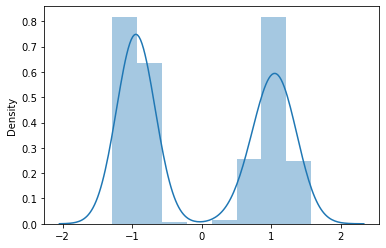

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


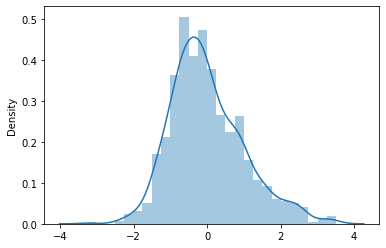

Test clean accuracy: 92.05
Test attack success rate: 41.26
50
tensor([0.5794], grad_fn=<IndexBackward0>) tensor(0.5722, grad_fn=<SelectBackward0>) tensor([0.0021], grad_fn=<IndexBackward0>)
tensor([0.6427], grad_fn=<IndexBackward0>) tensor(0.5366, grad_fn=<SelectBackward0>) tensor([0.0019], grad_fn=<IndexBackward0>)
tensor([0.7069], grad_fn=<IndexBackward0>) tensor(0.5145, grad_fn=<SelectBackward0>) tensor([0.0011], grad_fn=<IndexBackward0>)
tensor([0.7570], grad_fn=<IndexBackward0>) tensor(0.4930, grad_fn=<SelectBackward0>) tensor([0.0009], grad_fn=<IndexBackward0>)
tensor([0.7955], grad_fn=<IndexBackward0>) tensor(0.4792, grad_fn=<SelectBackward0>) tensor([0.0026], grad_fn=<IndexBackward0>)
tensor([0.8210], grad_fn=<IndexBackward0>) tensor(0.4658, grad_fn=<SelectBackward0>) tensor([0.0052], grad_fn=<IndexBackward0>)
tensor([0.8377], grad_fn=<IndexBackward0>) tensor(0.4509, grad_fn=<SelectBackward0>) tensor([0.0017], grad_fn=<IndexBackward0>)
tensor([0.8556], grad_fn=<IndexBackward0>)

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


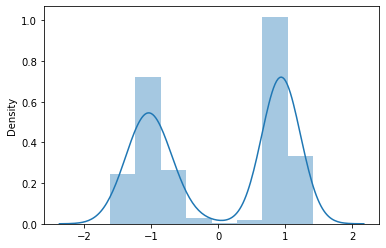

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


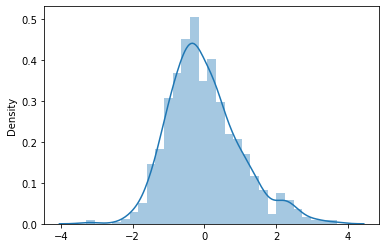

Test clean accuracy: 91.90
Test attack success rate: 23.72
54
tensor([0.5800], grad_fn=<IndexBackward0>) tensor(0.5587, grad_fn=<SelectBackward0>) tensor([0.5460], grad_fn=<IndexBackward0>)
tensor([0.5674], grad_fn=<IndexBackward0>) tensor(0.5531, grad_fn=<SelectBackward0>) tensor([0.0167], grad_fn=<IndexBackward0>)
tensor([0.5561], grad_fn=<IndexBackward0>) tensor(0.5489, grad_fn=<SelectBackward0>) tensor([0.2955], grad_fn=<IndexBackward0>)
tensor([0.5802], grad_fn=<IndexBackward0>) tensor(0.5405, grad_fn=<SelectBackward0>) tensor([0.4050], grad_fn=<IndexBackward0>)
tensor([0.5994], grad_fn=<IndexBackward0>) tensor(0.5362, grad_fn=<SelectBackward0>) tensor([0.4120], grad_fn=<IndexBackward0>)
tensor([0.6119], grad_fn=<IndexBackward0>) tensor(0.5324, grad_fn=<SelectBackward0>) tensor([0.4152], grad_fn=<IndexBackward0>)
tensor([0.6066], grad_fn=<IndexBackward0>) tensor(0.5252, grad_fn=<SelectBackward0>) tensor([0.4746], grad_fn=<IndexBackward0>)
tensor([0.5900], grad_fn=<IndexBackward0>)

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


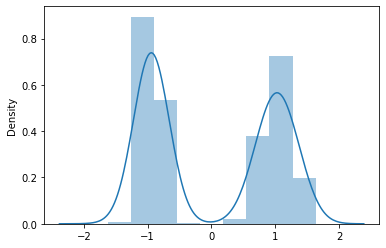

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


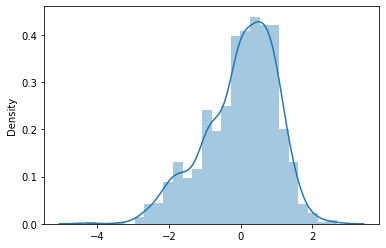

Test clean accuracy: 91.76
Test attack success rate: 24.08
57
tensor([0.5762], grad_fn=<IndexBackward0>) tensor(0.5551, grad_fn=<SelectBackward0>) tensor([0.6751], grad_fn=<IndexBackward0>)
tensor([0.5919], grad_fn=<IndexBackward0>) tensor(0.5488, grad_fn=<SelectBackward0>) tensor([0.5751], grad_fn=<IndexBackward0>)
tensor([0.5918], grad_fn=<IndexBackward0>) tensor(0.5434, grad_fn=<SelectBackward0>) tensor([0.4137], grad_fn=<IndexBackward0>)
tensor([0.5414], grad_fn=<IndexBackward0>) tensor(0.5409, grad_fn=<SelectBackward0>) tensor([0.7394], grad_fn=<IndexBackward0>)
tensor([0.5414], grad_fn=<IndexBackward0>) tensor(0.5348, grad_fn=<SelectBackward0>) tensor([0.7760], grad_fn=<IndexBackward0>)
tensor([0.5455], grad_fn=<IndexBackward0>) tensor(0.5291, grad_fn=<SelectBackward0>) tensor([0.7494], grad_fn=<IndexBackward0>)
tensor([0.5488], grad_fn=<IndexBackward0>) tensor(0.5277, grad_fn=<SelectBackward0>) tensor([0.5221], grad_fn=<IndexBackward0>)
tensor([0.5400], grad_fn=<IndexBackward0>)

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


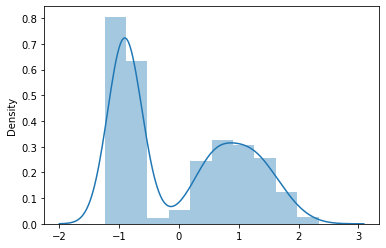

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


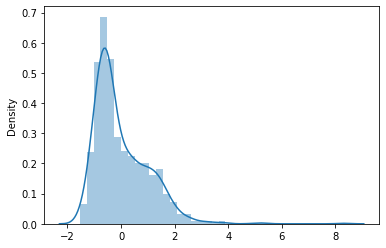

Test clean accuracy: 91.50
Test attack success rate: 18.82
63
tensor([0.5406], grad_fn=<IndexBackward0>) tensor(0.5205, grad_fn=<SelectBackward0>) tensor([0.6593], grad_fn=<IndexBackward0>)
tensor([0.5132], grad_fn=<IndexBackward0>) tensor(0.5120, grad_fn=<SelectBackward0>) tensor([0.0016], grad_fn=<IndexBackward0>)
tensor([0.5284], grad_fn=<IndexBackward0>) tensor(0.5094, grad_fn=<SelectBackward0>) tensor([0.0020], grad_fn=<IndexBackward0>)
tensor([0.5629], grad_fn=<IndexBackward0>) tensor(0.5072, grad_fn=<SelectBackward0>) tensor([0.0013], grad_fn=<IndexBackward0>)
tensor([0.5997], grad_fn=<IndexBackward0>) tensor(0.5017, grad_fn=<SelectBackward0>) tensor([0.0009], grad_fn=<IndexBackward0>)
tensor([0.6337], grad_fn=<IndexBackward0>) tensor(0.4950, grad_fn=<SelectBackward0>) tensor([0.0042], grad_fn=<IndexBackward0>)
tensor([0.6627], grad_fn=<IndexBackward0>) tensor(0.4861, grad_fn=<SelectBackward0>) tensor([0.0013], grad_fn=<IndexBackward0>)
tensor([0.6874], grad_fn=<IndexBackward0>)

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


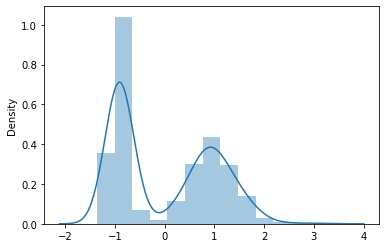

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


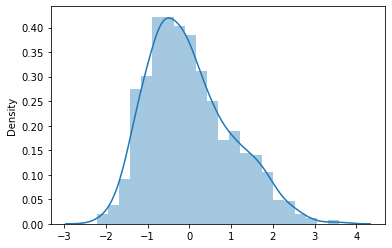

Test clean accuracy: 90.93
Test attack success rate: 29.54
66
tensor([0.5554], grad_fn=<IndexBackward0>) tensor(0.5369, grad_fn=<SelectBackward0>) tensor([0.0166], grad_fn=<IndexBackward0>)
tensor([0.5576], grad_fn=<IndexBackward0>) tensor(0.5299, grad_fn=<SelectBackward0>) tensor([0.3035], grad_fn=<IndexBackward0>)
tensor([0.5270], grad_fn=<IndexBackward0>) tensor(0.5261, grad_fn=<SelectBackward0>) tensor([0.0061], grad_fn=<IndexBackward0>)
tensor([0.5467], grad_fn=<IndexBackward0>) tensor(0.5242, grad_fn=<SelectBackward0>) tensor([0.6905], grad_fn=<IndexBackward0>)
tensor([0.5552], grad_fn=<IndexBackward0>) tensor(0.5224, grad_fn=<SelectBackward0>) tensor([0.2728], grad_fn=<IndexBackward0>)
tensor([0.5331], grad_fn=<IndexBackward0>) tensor(0.5172, grad_fn=<SelectBackward0>) tensor([0.2530], grad_fn=<IndexBackward0>)
tensor([0.5111], grad_fn=<IndexBackward0>) tensor(0.5105, grad_fn=<SelectBackward0>) tensor([0.1394], grad_fn=<IndexBackward0>)
tensor([0.5095], grad_fn=<IndexBackward0>)

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


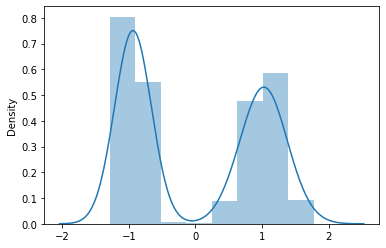

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


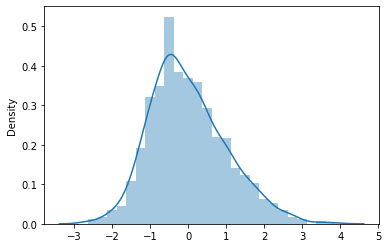

Test clean accuracy: 90.84
Test attack success rate: 8.17
69
tensor([0.5519], grad_fn=<IndexBackward0>) tensor(0.5189, grad_fn=<SelectBackward0>) tensor([0.5738], grad_fn=<IndexBackward0>)
tensor([0.5649], grad_fn=<IndexBackward0>) tensor(0.5082, grad_fn=<SelectBackward0>) tensor([0.6417], grad_fn=<IndexBackward0>)
tensor([0.5612], grad_fn=<IndexBackward0>) tensor(0.5018, grad_fn=<SelectBackward0>) tensor([0.4688], grad_fn=<IndexBackward0>)
tensor([0.5361], grad_fn=<IndexBackward0>) tensor(0.4963, grad_fn=<SelectBackward0>) tensor([0.5013], grad_fn=<IndexBackward0>)
tensor([0.4938], grad_fn=<IndexBackward0>) tensor(0.4931, grad_fn=<SelectBackward0>) tensor([0.2239], grad_fn=<IndexBackward0>)
tensor([0.5131], grad_fn=<IndexBackward0>) tensor(0.4897, grad_fn=<SelectBackward0>) tensor([0.0080], grad_fn=<IndexBackward0>)
tensor([0.5251], grad_fn=<IndexBackward0>) tensor(0.4882, grad_fn=<SelectBackward0>) tensor([0.2747], grad_fn=<IndexBackward0>)
tensor([0.5046], grad_fn=<IndexBackward0>) 

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


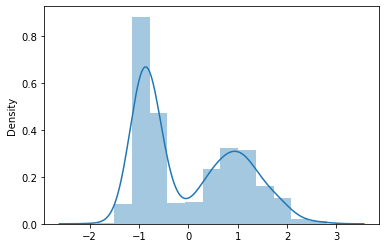

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


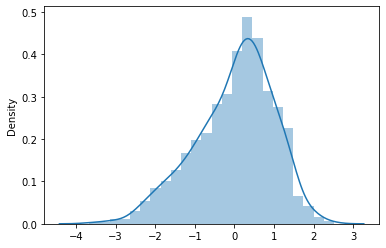

Test clean accuracy: 90.58
Test attack success rate: 7.86
73
tensor([0.5501], grad_fn=<IndexBackward0>) tensor(0.5434, grad_fn=<SelectBackward0>) tensor([1.1758e-05], grad_fn=<IndexBackward0>)
tensor([0.6039], grad_fn=<IndexBackward0>) tensor(0.5120, grad_fn=<SelectBackward0>) tensor([4.3476e-05], grad_fn=<IndexBackward0>)
tensor([0.6288], grad_fn=<IndexBackward0>) tensor(0.5009, grad_fn=<SelectBackward0>) tensor([0.0002], grad_fn=<IndexBackward0>)
tensor([0.6414], grad_fn=<IndexBackward0>) tensor(0.4889, grad_fn=<SelectBackward0>) tensor([0.0003], grad_fn=<IndexBackward0>)
tensor([0.6118], grad_fn=<IndexBackward0>) tensor(0.4880, grad_fn=<SelectBackward0>) tensor([0.0562], grad_fn=<IndexBackward0>)
tensor([0.5978], grad_fn=<IndexBackward0>) tensor(0.4856, grad_fn=<SelectBackward0>) tensor([0.0013], grad_fn=<IndexBackward0>)
tensor([0.6151], grad_fn=<IndexBackward0>) tensor(0.4794, grad_fn=<SelectBackward0>) tensor([0.5958], grad_fn=<IndexBackward0>)
tensor([0.6200], grad_fn=<IndexBack

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


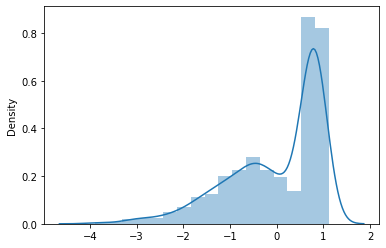

/home/v-runzheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


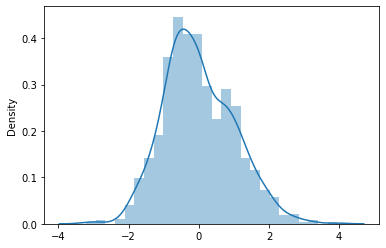

Test clean accuracy: 86.07
Test attack success rate: 0.33
76
tensor([0.5554], grad_fn=<IndexBackward0>) tensor(0.5228, grad_fn=<SelectBackward0>) tensor([0.6589], grad_fn=<IndexBackward0>)
tensor([0.5174], grad_fn=<IndexBackward0>) tensor(0.5084, grad_fn=<SelectBackward0>) tensor([0.6932], grad_fn=<IndexBackward0>)
tensor([0.5117], grad_fn=<IndexBackward0>) tensor(0.4949, grad_fn=<SelectBackward0>) tensor([0.6705], grad_fn=<IndexBackward0>)
tensor([0.4860], grad_fn=<IndexBackward0>) tensor(0.4826, grad_fn=<SelectBackward0>) tensor([0.5443], grad_fn=<IndexBackward0>)
tensor([0.4895], grad_fn=<IndexBackward0>) tensor(0.4762, grad_fn=<SelectBackward0>) tensor([0.0082], grad_fn=<IndexBackward0>)
tensor([0.5154], grad_fn=<IndexBackward0>) tensor(0.4725, grad_fn=<SelectBackward0>) tensor([0.6674], grad_fn=<IndexBackward0>)
tensor([0.4675], grad_fn=<IndexBackward0>) tensor(0.4657, grad_fn=<SelectBackward0>) tensor([0.4047], grad_fn=<IndexBackward0>)
tensor([0.4648], grad_fn=<IndexBackward0>) 

KeyboardInterrupt: 

In [159]:
ckpt = load_checkpoint(args)
state_dict, trigger = ckpt['state_dict'], ckpt['trigger']
net = get_model(args.model, num_classes).to(args.device)
net.load_state_dict(state_dict)

for i, (name, m) in enumerate(net.named_modules()):
    if isinstance(m, nn.Conv2d):
        print(i)
        if i > 2:
            with torch.no_grad():
                net(images[:1000].to(args.device))
            feat = m.feat.detach().cpu()
            orth_mat = geoopt.ManifoldParameter(manifold.random(m.weight.shape[1], m.weight.shape[1]))
            opt = RiemannianAdam([orth_mat], lr=5e-4)
            for i in range(5000):
                out = feat.matmul(orth_mat)
                out = (out - out.mean(0)) / out.std(0)

                skws = skewness(out)
                kurt = kurtosis(out)
                sbc = (skws**2+1)/kurt

                _, index = sbc.topk(1)

                entropy = kernel_entropy(out[index], n_bars=20, bw=0.1)

                if i % 100 == 0:
                    print(sbc[index], sbc.topk(2)[0][1], entropy[index])
    #                 print(sbc[index])
                loss = -sbc[index].mean() + sbc.topk(1+1)[0][-1] + entropy[index].mean()
                loss.backward()

    #             print(max_sbc, entropy)
    #             print(out[:, index].mean(), out[:, index].std())
                opt.step()

            index = sbc.topk(2)[1]
            sns.distplot(out[:, index[0]].cpu().detach())
            plt.show()
            sns.distplot(out[:, index[1]].cpu().detach())
            plt.show()
            weight = m.weight.cpu()
            
            orth_mat.detach_()
            orth_mat[:, index[0]] = 0
            orth_mat_I = orth_mat.matmul(orth_mat.T)
            new_weight = torch.einsum('jz, ijkl-> izkl', orth_mat_I, weight)
            
            state_dict = m.state_dict()
            state_dict['weight'] = new_weight
            m.load_state_dict(state_dict)
            acc, asr = val(net, test_clean_loader), val(net, test_poisoned_loader)
            print('Test clean accuracy: %.2f' % acc)
            print('Test attack success rate: %.2f' % asr)

In [17]:
ckpt = load_checkpoint(args)
state_dict, trigger = ckpt['state_dict'], ckpt['trigger']
net = get_model(args.model, num_classes).to(args.device)
net.load_state_dict(state_dict)
with torch.no_grad():
    net(images[:1000].to(args.device))

for i, (name, m) in enumerate(net.named_modules()):
    if isinstance(m, nn.BatchNorm2d):
        print(i)
        feat = m.feat.detach().cpu()
        orth_mat = geoopt.ManifoldParameter(manifold.random(m.weight.shape[0], m.weight.shape[0]))
        opt = RiemannianAdam([orth_mat], lr=1e-3)
        for i in range(1000):
            out = feat.matmul(orth_mat)
            out = (out - out.mean(0)) / out.std(0)
            
            skws = skewness(out)
            kurt = kurtosis(out)
            sbc = (skws**2+1)/kurt
            
            index = sbc.argmax()
            min_ = out[index].min().floor().item()
            max_ = out[index].max().ceil().item()
            step_size = (max_ - min_) / 100
            entropy = kernel_entropy(out[index], step_size=step_size, min_=min_, max_=max_, bw=0.1)
            
            loss = -sbc.max() + entropy
            loss.backward()
            
#             print(max_sbc, entropy)
#             print(out[:, index].mean(), out[:, index].std())
#             sns.distplot(out[:, index].cpu().detach())
#             plt.show()
            opt.step()
        print(sbc.max(), entropy)

        index = sbc.argmax()
        weight = m.weight
        new_weight = weight.matmul(orth_mat.cuda())
        new_weight[index] = 0
        new_weight = new_weight.matmul(orth_mat.T.cuda())
        state_dict = m.state_dict()
        state_dict['weight'] = new_weight
        m.load_state_dict(state_dict)
        acc, asr = val(net, test_clean_loader), val(net, test_poisoned_loader)
        print('Test clean accuracy: %.2f' % acc)
        print('Test attack success rate: %.2f' % asr)

Checkpoint loaded from ./ckpt/resnet18_blended_32_0.1_0.pth
3
tensor(0.7896, grad_fn=<MaxBackward1>) tensor(3.6847, grad_fn=<NegBackward0>)
Test clean accuracy: 94.58
Test attack success rate: 99.56
9
tensor(0.8581, grad_fn=<MaxBackward1>) tensor(3.1464, grad_fn=<NegBackward0>)
Test clean accuracy: 94.47
Test attack success rate: 98.56
12
tensor(0.8857, grad_fn=<MaxBackward1>) tensor(3.4298, grad_fn=<NegBackward0>)
Test clean accuracy: 94.24
Test attack success rate: 96.98
17
tensor(0.8318, grad_fn=<MaxBackward1>) tensor(3.5596, grad_fn=<NegBackward0>)
Test clean accuracy: 93.95
Test attack success rate: 93.08
20
tensor(0.8167, grad_fn=<MaxBackward1>) tensor(3.2450, grad_fn=<NegBackward0>)
Test clean accuracy: 93.97
Test attack success rate: 92.84
26
tensor(0.8790, grad_fn=<MaxBackward1>) tensor(3.3174, grad_fn=<NegBackward0>)
Test clean accuracy: 93.97
Test attack success rate: 94.72
29
tensor(0.8755, grad_fn=<MaxBackward1>) tensor(3.1801, grad_fn=<NegBackward0>)
Test clean accuracy: 

In [9]:
import numpy as np

def gaussian(x, std=1):
    return 1/np.sqrt(2*np.pi*std**2) * torch.exp(-x**2/(2*std**2))


def kernel_entropy(x, n_bars=100, bw=1, eps=1e-6):
    min_ = x.min().floor().item()
    max_ = x.max().ceil().item()
    step_size = (max_ - min_) / n_bars

    n, c = x.shape
    Z = torch.zeros(c).to(x.device)
    ps = torch.zeros(c, math.ceil((max_-min_)/step_size)).to(x.device)
    for i, k in enumerate(np.arange(min_, max_, step_size)):
        z = gaussian(x - k, bw).sum(0)
        Z += z
        ps[:, i] = z
    ps = ps / Z.unsqueeze(-1)
    entropy = - (ps * (ps+eps).log()).sum(-1)
    return entropy


In [76]:
ckpt = load_checkpoint(args)
state_dict, trigger = ckpt['state_dict'], ckpt['trigger']
net = get_model(args.model, num_classes).to(args.device)
net.load_state_dict(state_dict)

for i, (name, m) in enumerate(net.named_modules()):
    if isinstance(m, nn.BatchNorm2d):
        print(i)
        with torch.no_grad():
            net(images[:1000].to(args.device))
        feat = m.feat.detach().cpu()
        orth_mat = geoopt.ManifoldParameter(manifold.random(m.weight.shape[0], m.weight.shape[0]))
        opt = RiemannianAdam([orth_mat], lr=1e-4)
        for i in range(5000):
            out = feat.matmul(orth_mat)
            out = (out - out.mean(0)) / out.std(0)

            skws = skewness(out)
            kurt = kurtosis(out)
            sbc = (skws**2+1)/kurt
            
            index = sbc.argmax()
            
            loss = -sbc.max()
            loss.backward()
            
#             print(max_sbc)
#             print(out[:, index].mean(), out[:, index].std())
#             sns.distplot(out[:, index].cpu().detach())
#             plt.show()
            opt.step()
        print(sbc.max(), sbc.mean())

        index = sbc.argmax()
        weight = m.weight
        new_weight = weight.matmul(orth_mat.cuda())
        new_weight[index] = 0
        new_weight = new_weight.matmul(orth_mat.T.cuda())
        state_dict = m.state_dict()
        state_dict['weight'] = new_weight
        m.load_state_dict(state_dict)
        acc, asr = val(net, test_clean_loader), val(net, test_poisoned_loader)
        print('Test clean accuracy: %.2f' % acc)
        print('Test attack success rate: %.2f' % asr)

Checkpoint loaded from ./ckpt/resnet18_badnets_3_0.1_0.pth
3
tensor(0.8033, grad_fn=<MaxBackward1>) tensor(0.3706, grad_fn=<MeanBackward0>)
Test clean accuracy: 93.57
Test attack success rate: 100.00
9
tensor(0.8836, grad_fn=<MaxBackward1>) tensor(0.4214, grad_fn=<MeanBackward0>)
Test clean accuracy: 93.37
Test attack success rate: 100.00
12
tensor(0.8443, grad_fn=<MaxBackward1>) tensor(0.4389, grad_fn=<MeanBackward0>)
Test clean accuracy: 93.47
Test attack success rate: 99.98
17
tensor(0.8862, grad_fn=<MaxBackward1>) tensor(0.4252, grad_fn=<MeanBackward0>)
Test clean accuracy: 93.25
Test attack success rate: 98.80
20
tensor(0.8583, grad_fn=<MaxBackward1>) tensor(0.4136, grad_fn=<MeanBackward0>)
Test clean accuracy: 93.19
Test attack success rate: 97.93
26
tensor(0.8601, grad_fn=<MaxBackward1>) tensor(0.3718, grad_fn=<MeanBackward0>)
Test clean accuracy: 93.20
Test attack success rate: 95.73
29
tensor(0.7890, grad_fn=<MaxBackward1>) tensor(0.3468, grad_fn=<MeanBackward0>)
Test clean ac

KeyboardInterrupt: 

In [72]:
ckpt = load_checkpoint(args)
state_dict, trigger = ckpt['state_dict'], ckpt['trigger']
net = get_model(args.model, num_classes).to(args.device)
net.load_state_dict(state_dict)
with torch.no_grad():
    net(images[:1000].to(args.device))

for i, (name, m) in enumerate(net.named_modules()):
    if isinstance(m, nn.BatchNorm2d):
        print(i)
        feat = m.feat.detach().cpu()
        orth_mat = geoopt.ManifoldParameter(manifold.random(m.weight.shape[0], m.weight.shape[0]))
        opt = RiemannianAdam([orth_mat], lr=1e-4)
        for i in range(5000):
            out = feat.matmul(orth_mat)
            out = (out - out.mean(0)) / out.std(0)

            skws = skewness(out)
            kurt = kurtosis(out)
            sbc = (skws**2+1)/kurt
            
            index = sbc.argmax()
            
            loss = -sbc.max()
#             loss = -20*sbc.max() + sbc.sum()
            loss.backward()
            
#             print(max_sbc)
#             print(out[:, index].mean(), out[:, index].std())
#             sns.distplot(out[:, index].cpu().detach())
#             plt.show()
            opt.step()
        print(sbc.max())

        index = sbc.argmax()
        weight = m.weight
        new_weight = weight.matmul(orth_mat.cuda())
        new_weight[index] = 0
        new_weight = new_weight.matmul(orth_mat.T.cuda())
        state_dict = m.state_dict()
        state_dict['weight'] = new_weight
        m.load_state_dict(state_dict)
        acc, asr = val(net, test_clean_loader), val(net, test_poisoned_loader)
        print('Test clean accuracy: %.2f' % acc)
        print('Test attack success rate: %.2f' % asr)

Checkpoint loaded from ./ckpt/resnet18_badnets_3_0.1_0.pth
3
tensor(0.8020, grad_fn=<MaxBackward1>)
Test clean accuracy: 93.56
Test attack success rate: 100.00
9
tensor(0.8724, grad_fn=<MaxBackward1>)
Test clean accuracy: 93.43
Test attack success rate: 100.00
12
tensor(0.8559, grad_fn=<MaxBackward1>)
Test clean accuracy: 93.41
Test attack success rate: 100.00
17
tensor(0.8956, grad_fn=<MaxBackward1>)
Test clean accuracy: 93.29
Test attack success rate: 99.94
20
tensor(0.8609, grad_fn=<MaxBackward1>)
Test clean accuracy: 93.25
Test attack success rate: 99.79
26
tensor(0.8562, grad_fn=<MaxBackward1>)
Test clean accuracy: 93.30
Test attack success rate: 98.94
29
tensor(0.7841, grad_fn=<MaxBackward1>)
Test clean accuracy: 93.00
Test attack success rate: 81.82
32
tensor(0.8592, grad_fn=<MaxBackward1>)
Test clean accuracy: 93.00
Test attack success rate: 77.28
36
tensor(0.8608, grad_fn=<MaxBackward1>)
Test clean accuracy: 92.99
Test attack success rate: 73.78
39
tensor(0.8761, grad_fn=<MaxB

KeyboardInterrupt: 